In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import seaborn as sns
import pickle
import scipy.io as sio

from matplotlib.transforms import ScaledTranslation
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from tqdm import tqdm
from nn_FNO import FNO1d
from nn_MLP import *
from nn_step_methods import *
from ensemble_FP import ensemble_FP
from Obs_func_generator import EnsKFstep_module
from nn_FP_net import *
import hdf5storage

2.1.1+cu121
2.1.1+cu121
2.1.1+cu121
2.1.1+cu121


In [2]:
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/training_data/KS_1024.pkl', 'rb') as f: #change based on eval data location.
    test = pickle.load(f)
test=np.asarray(test[:,150000:250000]).T
print(test.shape)

device = 'cuda'

(100000, 1024)


In [3]:
file_names = [
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_MLP_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_MLP_tendency_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_RK4step_MLP_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_RK4step_MLP_tendency_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_MLP_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_MLP_tendency_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_tendency_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_RK4step_FNO_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_RK4step_FNO_tendency_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_FNO_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_FNO_tendency_jacs_many_timesteps.npy',


'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_jac_loss_MLP_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_spectral_jac_loss_MLP_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_MLP_test_loss_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_MLP_spectral_jac_loss_jacs_many_timesteps.npy', 
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_RK4step_FNO_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_RK4step_spectral_jac_loss_MLP_jacs_many_timesteps.npy',


'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_jac_loss_jacs_many_timesteps.npy',    
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_spectral_jac_loss_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_jacobian_FNO_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_spectral_jacobian_FNO_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_RK4step_jacobian_FNO_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_RK4step_spectral_jacobian_FNO_jacs_many_timesteps.npy',


'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Directstep_MLP_jacs_many_timesteps.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Directstep_FNO_jacs_many_timesteps.npy',

]


labels = [
'Euler MLP','Euler MLP spectral loss','RK4 MLP','RK4 MLP spectral loss','PEC4 MLP',
'PEC4 MLP spectral loss',

'Euler FNO','Euler FNO spectral loss','RK4 FNO',
'RK4 FNO spectral loss',
'PEC4 FNO','PEC4 FNO spectral loss',
    
'Euler MLP jacobian loss',
'Euler MLP spectral jacobian loss',
'PEC4 MLP jacobian loss',
'PEC4 MLP spectral jacobian loss',
'RK4 MLP jacobian loss',
'RK4 MLP spectral jacobian loss',

'Euler FNO jacobian loss',
'Euler FNO spectral jacobian loss',
'PEC4 FNO jacobian loss',
'PEC4 FNO spectral jacobian loss',
'RK4 FNO jacobian loss',
'RK4 FNO spectral jacobian loss',

'Direct Step MLP','Direct Step FNO',
]
markers = ['o','+','*','^','v','1','s','p','X','x','p','.','2','|','+','o','+','*','^','v','1','s','p','X','x','p','.','2','|','+']




file_names_implicit = [
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_jacs_many_timesteps_lead_50.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_jacs_many_timesteps_lead_100.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Implicit_Eulerstep_FNO_jacs_many_timesteps_lead_50.npy',
'/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Implicit_Eulerstep_FNO_jacs_many_timesteps_lead_100.npy',
]

labels_implicit = [
    'Euler FNO dt=50',
    'Euler FNO dt=100',
    'Euler FNO implicit dt=50',
    'Euler FNO implicit dt=100',
]


In [4]:
out_norm_vals = []
trange= 100
out_RMSE_vals = np.zeros([len(file_names), trange])
x_vals = np.zeros([len(file_names)])
y_vals = np.zeros([len(file_names)])
net_eigvals_all = np.zeros([len(file_names), 1024], dtype = complex)
count = 0

for name in file_names:
    with open(name, 'rb') as f: #change based on eval data location.
        data_dict = np.load(f, allow_pickle=True)
    net_pred = data_dict.item()['prediction']
    net_truth = data_dict.item()['Truth']
    net_RMSE = data_dict.item()['RMSE']
    # net_FFT_x = data_dict.item()['pred_FFT_x']
    net_jacs = data_dict.item()['Jacobians']
    net_eigvals, net_eigvecs = np.linalg.eig(net_jacs[0])
    residuals = net_truth[0:2] - net_pred[0:2]
    # if count > 11:
    #     residuals = net_truth[0:2] - net_pred[0:2]
        # print(name)
    # residuals = residuals / np.linalg.norm(residuals, axis=1)[:, None]
    # out_norm = np.linalg.norm(net_jacs[10] @ residuals[10])
    # net_eigvals[net_eigvals<1] = 0
    # out_norm = (net_eigvals @ np.abs(net_eigvecs.T @ residuals[10])).real
    # out_norm = (net_eigvals[0] * (net_eigvecs.T[0,:] @ residuals[0])).real
    # out_norm = np.abs(net_eigvals).max()
    # out_norm = np.linalg.norm(net_jacs[0:2] @ residuals[0:2,:,None], axis=1).sum()   
    
    # y_vals[count] = np.linalg.norm(residuals[1:2], axis=1)[0] /np.linalg.norm(residuals[0:1], axis=1)[0]
    # x_vals[count] = np.abs(net_eigvals).max()
    
    y_vals[count] = np.linalg.norm(residuals[1:2], axis=1)[0]
    x_vals[count] = np.abs(net_eigvals).max() * np.linalg.norm(residuals[0:1], axis=1)[0]

    out_RMSE_vals[count] = net_RMSE[0:trange,0]
    net_eigvals_all[count] = net_eigvals
    print(count)
    count += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


2.001333525897418
2.000192914463119
[<Axes: xlabel='$|\\lambda_{max}| ||e(t)||$', ylabel='$||e(t+ \\Delta t)||$'>
 <Axes: xlabel='$|\\lambda_{max}| ||e(t)||$', ylabel='$||e(t+\\Delta t)||$'>]


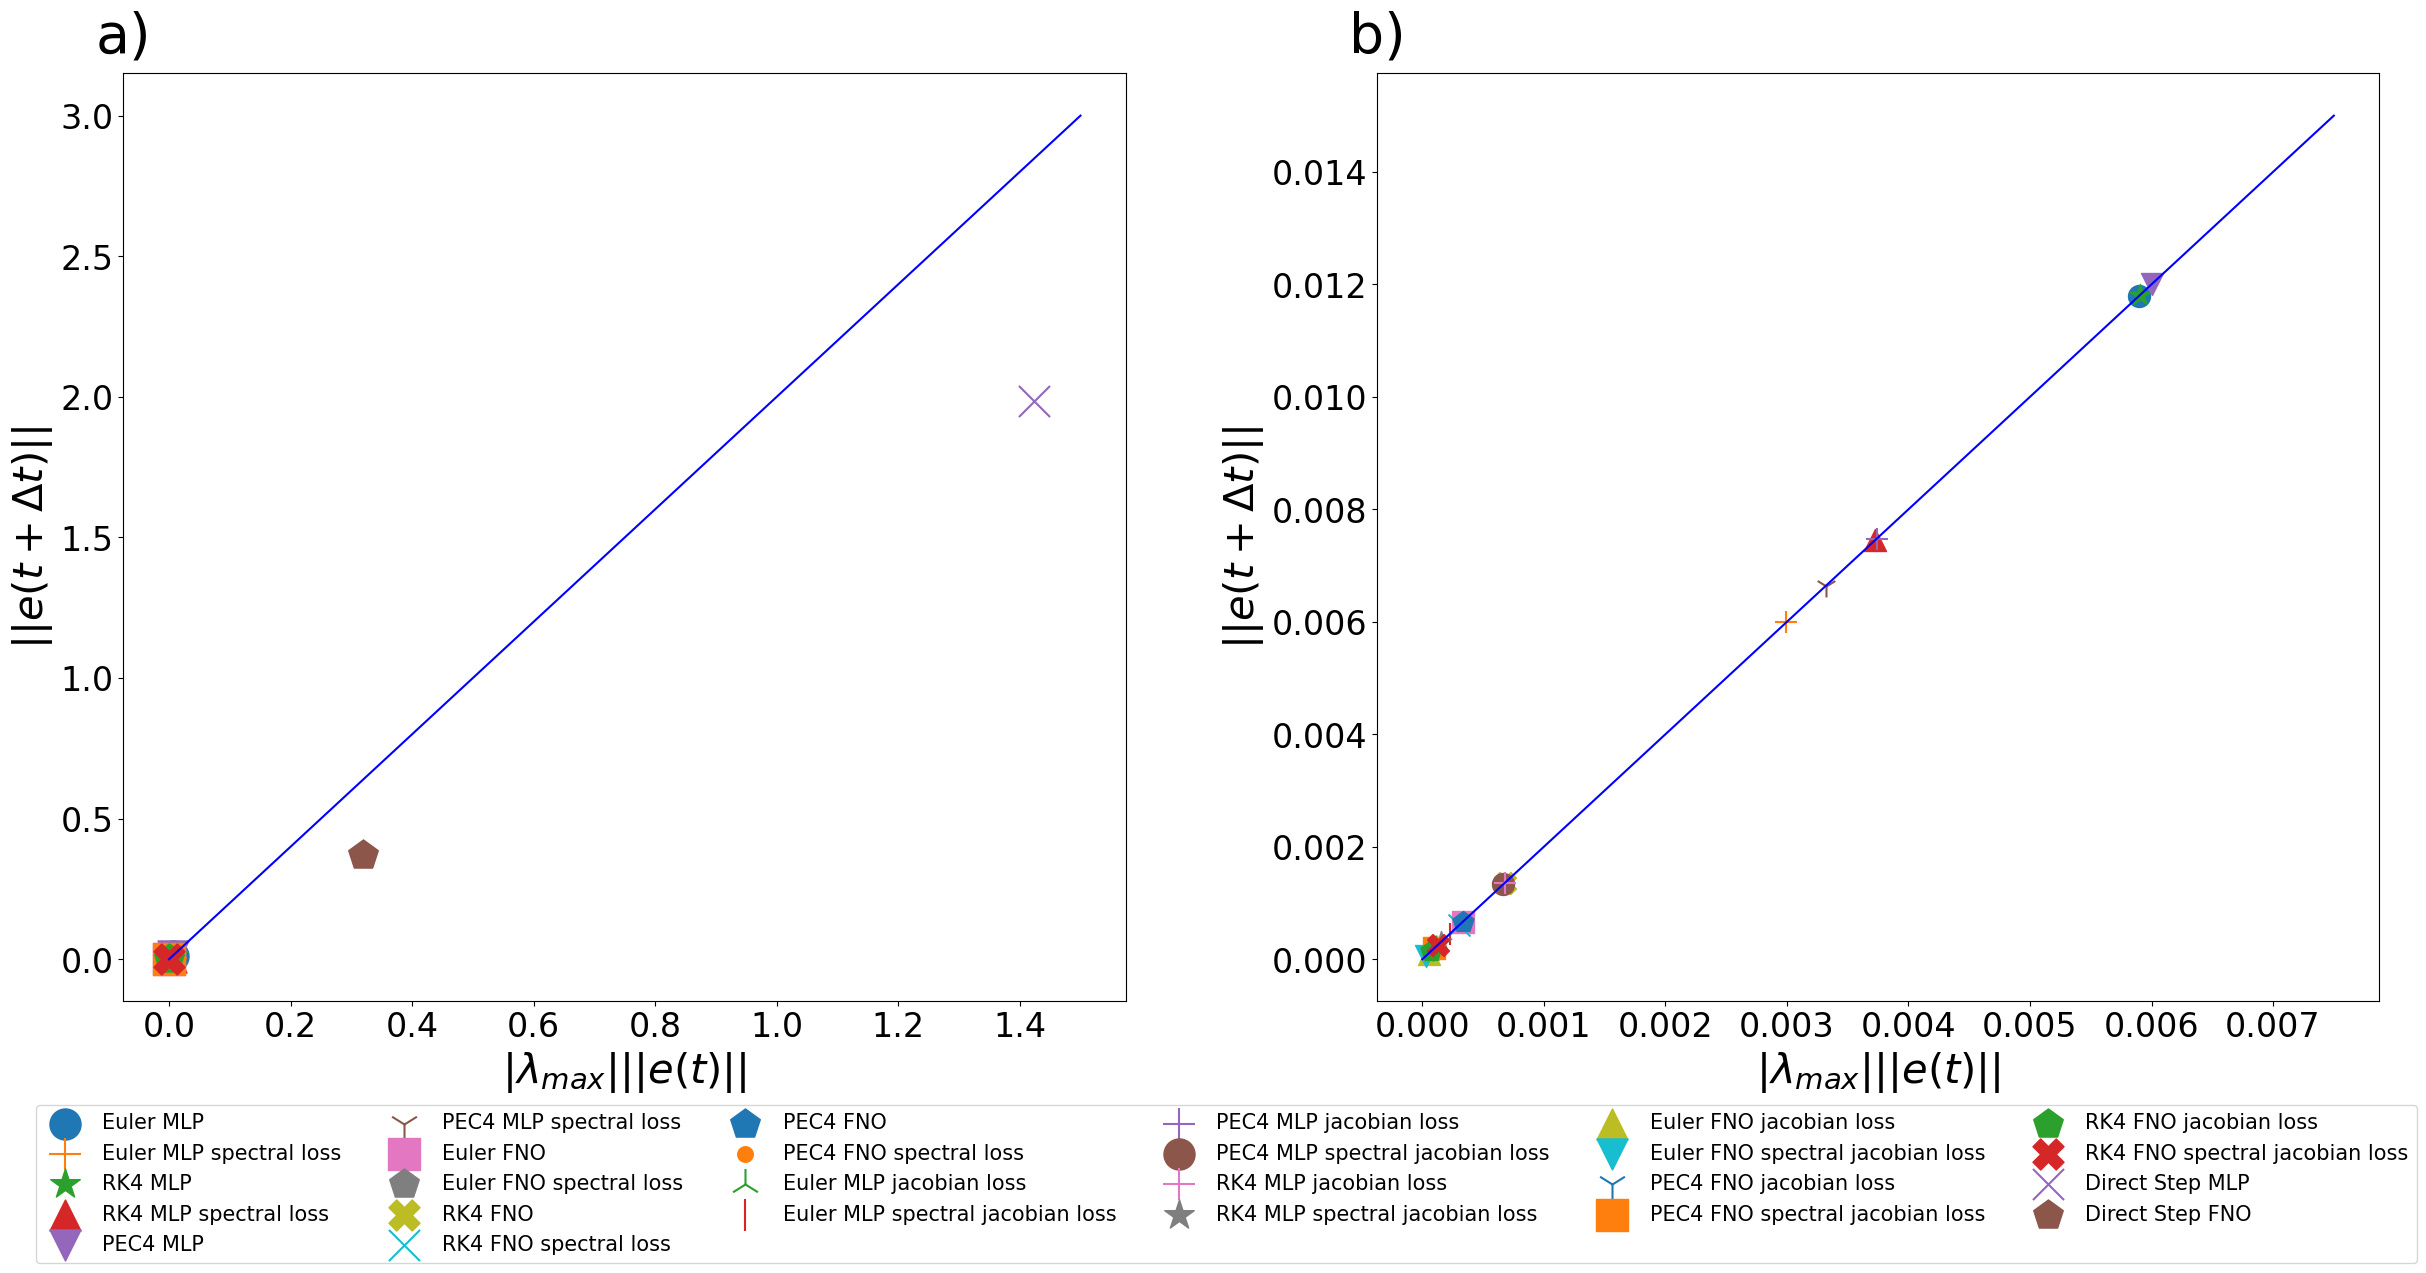

In [16]:
m_1, b_1 = np.polyfit(x_vals[:2], y_vals[:2], 1)  # 1 for linear regression
m_2, b_2 = np.polyfit(x_vals[:-2], y_vals[:-2], 1)  # 1 for linear regression
fig, axs = plt.subplots(1,2, figsize=(24,16))
for i in range(len(file_names)):
    # print(x_vals[i], y_vals[i], markers[i], labels[i])
    axs[0].scatter(x_vals[i], y_vals[i], marker=markers[i], label=labels[i], s=500)
x = np.linspace(0, 1.5, num=1000)
# plt.plot(x, m_1*x + b_1, label='Best fit directstep')
axs[0].plot(x, m_2*x + b_2, color='blue')
print(m_1)
axs[0].set_ylabel(r'$||e(t+ \Delta t)||$', fontsize=30)
axs[0].set_xlabel(r'$|\lambda_{max}| ||e(t)||$', fontsize=30)
# axs[0].legend(bbox_to_anchor=(-.3, 1), prop={'size':10})
axs[0].xaxis.set_tick_params(labelsize=24)
axs[0].yaxis.set_tick_params(labelsize=24)
# plt.xscale('log')
# plt.yscale('log')
# axs[0].set_title('Largest Eigevalue and MSE of all methods', fontsize=30)



for i in range(0, len(file_names)-2):
    # print(x_vals[i], y_vals[i], markers[i], labels[i])
    axs[1].scatter(x_vals[i], y_vals[i], marker=markers[i], label=labels[i], s=250)
x = np.linspace(0, 0.0075, num=1000)
# plt.plot(x, m_1*x + b_1, label='Best fit directstep')
axs[1].plot(x, m_2*x + b_2, color='blue')
print(m_2)
axs[1].set_ylabel(r'$||e(t+\Delta t)||$', fontsize=30)
axs[1].set_xlabel(r'$|\lambda_{max}| ||e(t)||$', fontsize=30)
# axs[1].legend(prop={'size':6})
# axs[1].set_title('Largest Eigevalue and MSE of all first order and higher methods', fontsize=30)
axs[1].xaxis.set_tick_params(labelsize=24)
axs[1].yaxis.set_tick_params(labelsize=24)


letters = ['a)', 'b)']
print(axs)
for indx, ax in enumerate(axs):
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    ax.text(
        0.0, 1.0, letters[indx], transform=(
            ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize='40', va='bottom')
fig.subplots_adjust(bottom=0.3, wspace=0.33)

axs[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.1), ncol=6, prop={'size':15})
plt.subplots_adjust(left=0.01, right=0.95, wspace=0.25, hspace=0.25)

# fig.tight_layout()
# fig.savefig('Figure_2.png', dpi=fig.dpi, bbox_inches='tight')

In [76]:
file_names = [
              '/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_MLP_jacs_many_timesteps.npy',
              '/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_MLP_tendency_jacs_many_timesteps.npy',
              '/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_RK4step_MLP_jacs_many_timesteps.npy',
              '/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_RK4step_MLP_tendency_jacs_many_timesteps.npy',
              '/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_MLP_jacs_many_timesteps.npy',
              '/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_MLP_tendency_jacs_many_timesteps.npy',
              '/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_jacs_many_timesteps.npy',
              '/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_tendency_jacs_many_timesteps.npy',
              '/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_RK4step_FNO_jacs_many_timesteps.npy',
              '/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_RK4step_FNO_tendency_jacs_many_timesteps.npy',
              # '/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_FNO_jacs_many_timesteps.npy',
              '/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_FNO_tendency_jacs_many_timesteps.npy'
]
labels = [ 
            'Eulerstep_MLP','Eulerstep_MLP_tendency','RK4step_MLP',
            'RK4step_MLP_tendency',
            'PEC4step_MLP',
            'PEC4step_MLP_tendency',
    
            'Eulerstep_FNO',
            'Eulerstep_FNO_tendency',
            'RK4step_FNO',
            'RK4step_FNO_tendency',
            # 'PEC4step_FNO',
            'PEC4step_FNO_tendency'
         ]
markers = ['o','+','*','^','v','1','s','p','X','x','p','.','2','|' ]

In [ ]:
# data_dict.item()['Pred_from_Truth']
# data_dict.item()['Truth_indices']
count = 0
x_vals_full = np.zeros([len(file_names)])
for name in file_names:
    with open(name, 'rb') as f: #change based on eval data location.
        data_dict = np.load(f, allow_pickle=True)
    net_pred = data_dict.item()['prediction']
    net_truth = data_dict.item()['Truth']
    net_RMSE = data_dict.item()['RMSE']
    net_jacs = data_dict.item()['Jacobians']
    # pred_stack = data_dict.item()['Pred_from_Truth']
    # temp = np.array(data_dict.item()['Truth_indices'])
    # temp = np.array(range(len(temp)))
    # print('Data loaded')
    # temp1 = net_truth[temp]
    # temp2 = net_truth[temp+1]
    # temp3 = net_truth[temp+2]
    # truth_stack = np.swapaxes(np.stack([temp1, temp2, temp3], axis=2), 1, 2)
    net_eigvals, net_eigvecs = np.linalg.eig(net_jacs[0])
    # residuals = pred_stack - truth_stack
    # y_vals = np.divide(np.linalg.norm(residuals[0:50, 1:2], axis=2)[0:50, 0], np.linalg.norm(residuals[0:50,0:1], axis=2)[:, 0])
    y_vals = np.linalg.norm(residuals[0:50, 1:2], axis=2)
    # print(net_eigvals.shape)
    x_vals = np.max(np.abs(net_eigvals), axis=1) * np.linalg.norm(residuals[0:50, 0:1], axis=2)[:,0]
    plt.scatter(x_vals, y_vals, marker=markers[count], label=labels[count], s=100)
    count += 1
    print(count)
# plt.ylim(bottom=0.95)
plt.ylabel(r'$||e(t+1)||$')
plt.xlabel(r'$|\lambda_{max}| ||e(t)||$')
plt.subplots_adjust(left=0.01, right=0.95, wspace=0.25, hspace=0.25)

plt.legend(prop={'size':7}, loc='upper center')

In [ ]:
fig, ax = plt.subplots(dpi=70)
plt.bar(range(len(file_names)), out_norm_vals)
plt.ylim(min(out_norm_vals), max(out_norm_vals))
plt.xticks(range(len(file_names)), labels, rotation=90)
ax.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False)
print('')

In [ ]:
fig, ax = plt.subplots(dpi=100)
tstart = 0
tend = 10000
for k in range(len(labels)):
    if k<6:
        plt.plot(out_RMSE_vals[k,tstart:tend],':', label=labels[k])
    else:
        plt.plot(out_RMSE_vals[k,tstart:tend], label=labels[k])
plt.legend(prop={'size':7})
print('')

In [ ]:
fig, ax = plt.subplots(dpi=70)
tstart = 0
tend = 100000
for k in range(len(labels)):
    plt.plot(out_RMSE_vals[k,tstart:tend], label=labels[k])
plt.legend()
print('')

In [ ]:
fig, ax = plt.subplots(dpi=70)
tstart = 0
tend = 10000
for k in range(len(labels)):
    plt.plot(out_RMSE_vals[k,tstart:tend], label=labels[k])
plt.legend()
print('')

In [ ]:
fig, ax = plt.subplots(dpi=70)
tstart = 0
tend = 10000
for k in range(1,len(labels)):
    plt.plot(out_RMSE_vals[k,tstart:tend], label=labels[k])
plt.legend()
print('')

In [4]:
trange = 1000
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_tendency_pred_jacs.npy', 'rb') as f: #change based on eval data location.
    data_dict = np.load(f, allow_pickle=True)
net_pred = data_dict.item()['prediction']
net_truth = data_dict.item()['Truth']
net_RMSE = data_dict.item()['RMSE']
net_FFT_x = data_dict.item()['pred_FFT_x']
net_jacs = data_dict.item()['Jacobians']
# net_pred_from_truch = data_dict.item()['Pred_from_Truth']
# net_truth_indices = data_dict.item()['Truth_indices']

with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_pred_jacs.npy', 'rb') as f: #change based on eval data location.
    data_dict = np.load(f, allow_pickle=True)
net_2_pred = data_dict.item()['prediction']
net_2_RMSE = data_dict.item()['RMSE']
net_2_FFT_x = data_dict.item()['pred_FFT_x']
net_2_jacs = data_dict.item()['Jacobians']

with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_RK4step_FNO_pred_jacs.npy', 'rb') as f: #change based on eval data location.
    data_dict = np.load(f, allow_pickle=True)
net_3_pred = data_dict.item()['prediction']
net_3_RMSE = data_dict.item()['RMSE']
net_3_FFT_x = data_dict.item()['pred_FFT_x']
net_3_jacs = data_dict.item()['Jacobians']



with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_FNO_pred_jacs.npy', 'rb') as f: #change based on eval data location.
    data_dict = np.load(f, allow_pickle=True)
net_4_pred = data_dict.item()['prediction']
net_4_RMSE = data_dict.item()['RMSE']
net_4_FFT_x = data_dict.item()['pred_FFT_x']
net_4_jacs = data_dict.item()['Jacobians']



with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_FNO_tendency_pred_jacs.npy', 'rb') as f: #change based on eval data location.
    data_dict = np.load(f, allow_pickle=True)
net_5_pred = data_dict.item()['prediction']
net_5_RMSE = data_dict.item()['RMSE']
net_5_FFT_x = data_dict.item()['pred_FFT_x']
net_5_jacs = data_dict.item()['Jacobians']



with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_RK4step_FNO_tendency_pred_jacs.npy', 'rb') as f: #change based on eval data location.
    data_dict = np.load(f, allow_pickle=True)
net_6_pred = data_dict.item()['prediction']
net_6_RMSE = data_dict.item()['RMSE']
net_6_FFT_x = data_dict.item()['pred_FFT_x']
net_6_jacs = data_dict.item()['Jacobians']

In [5]:
trange = 10000
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Directstep_FNO_jacs_many_timesteps.npy', 'rb') as f: #change based on eval data location.
    data_dict = np.load(f, allow_pickle=True)
net_pred = data_dict.item()['prediction']
net_truth = data_dict.item()['Truth']
net_RMSE = data_dict.item()['RMSE']
# net_RMSE = np.sqrt(np.mean((net_pred[0:trange] - net_truth[1:trange+1])**2, axis=1) )
net_FFT_x = data_dict.item()['pred_FFT_x']
net_jacs = data_dict.item()['Jacobians']
# net_pred_from_truch = data_dict.item()['Pred_from_Truth']
# net_truth_indices = data_dict.item()['Truth_indices']
net_eigvals, net_eigvecs = np.linalg.eig(net_jacs[0])

with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_jacs_many_timesteps.npy', 'rb') as f: #change based on eval data location.
    data_dict = np.load(f, allow_pickle=True)
net_2_pred = data_dict.item()['prediction']
net_2_RMSE = data_dict.item()['RMSE']
# net_2_RMSE = np.sqrt(np.mean((net_2_pred[0:trange] - net_truth[1:trange+1])**2, axis=1) )
net_2_FFT_x = data_dict.item()['pred_FFT_x']
net_2_jacs = data_dict.item()['Jacobians']

net_2_eigvals, net_2_eigvecs = np.linalg.eig(net_2_jacs[0])

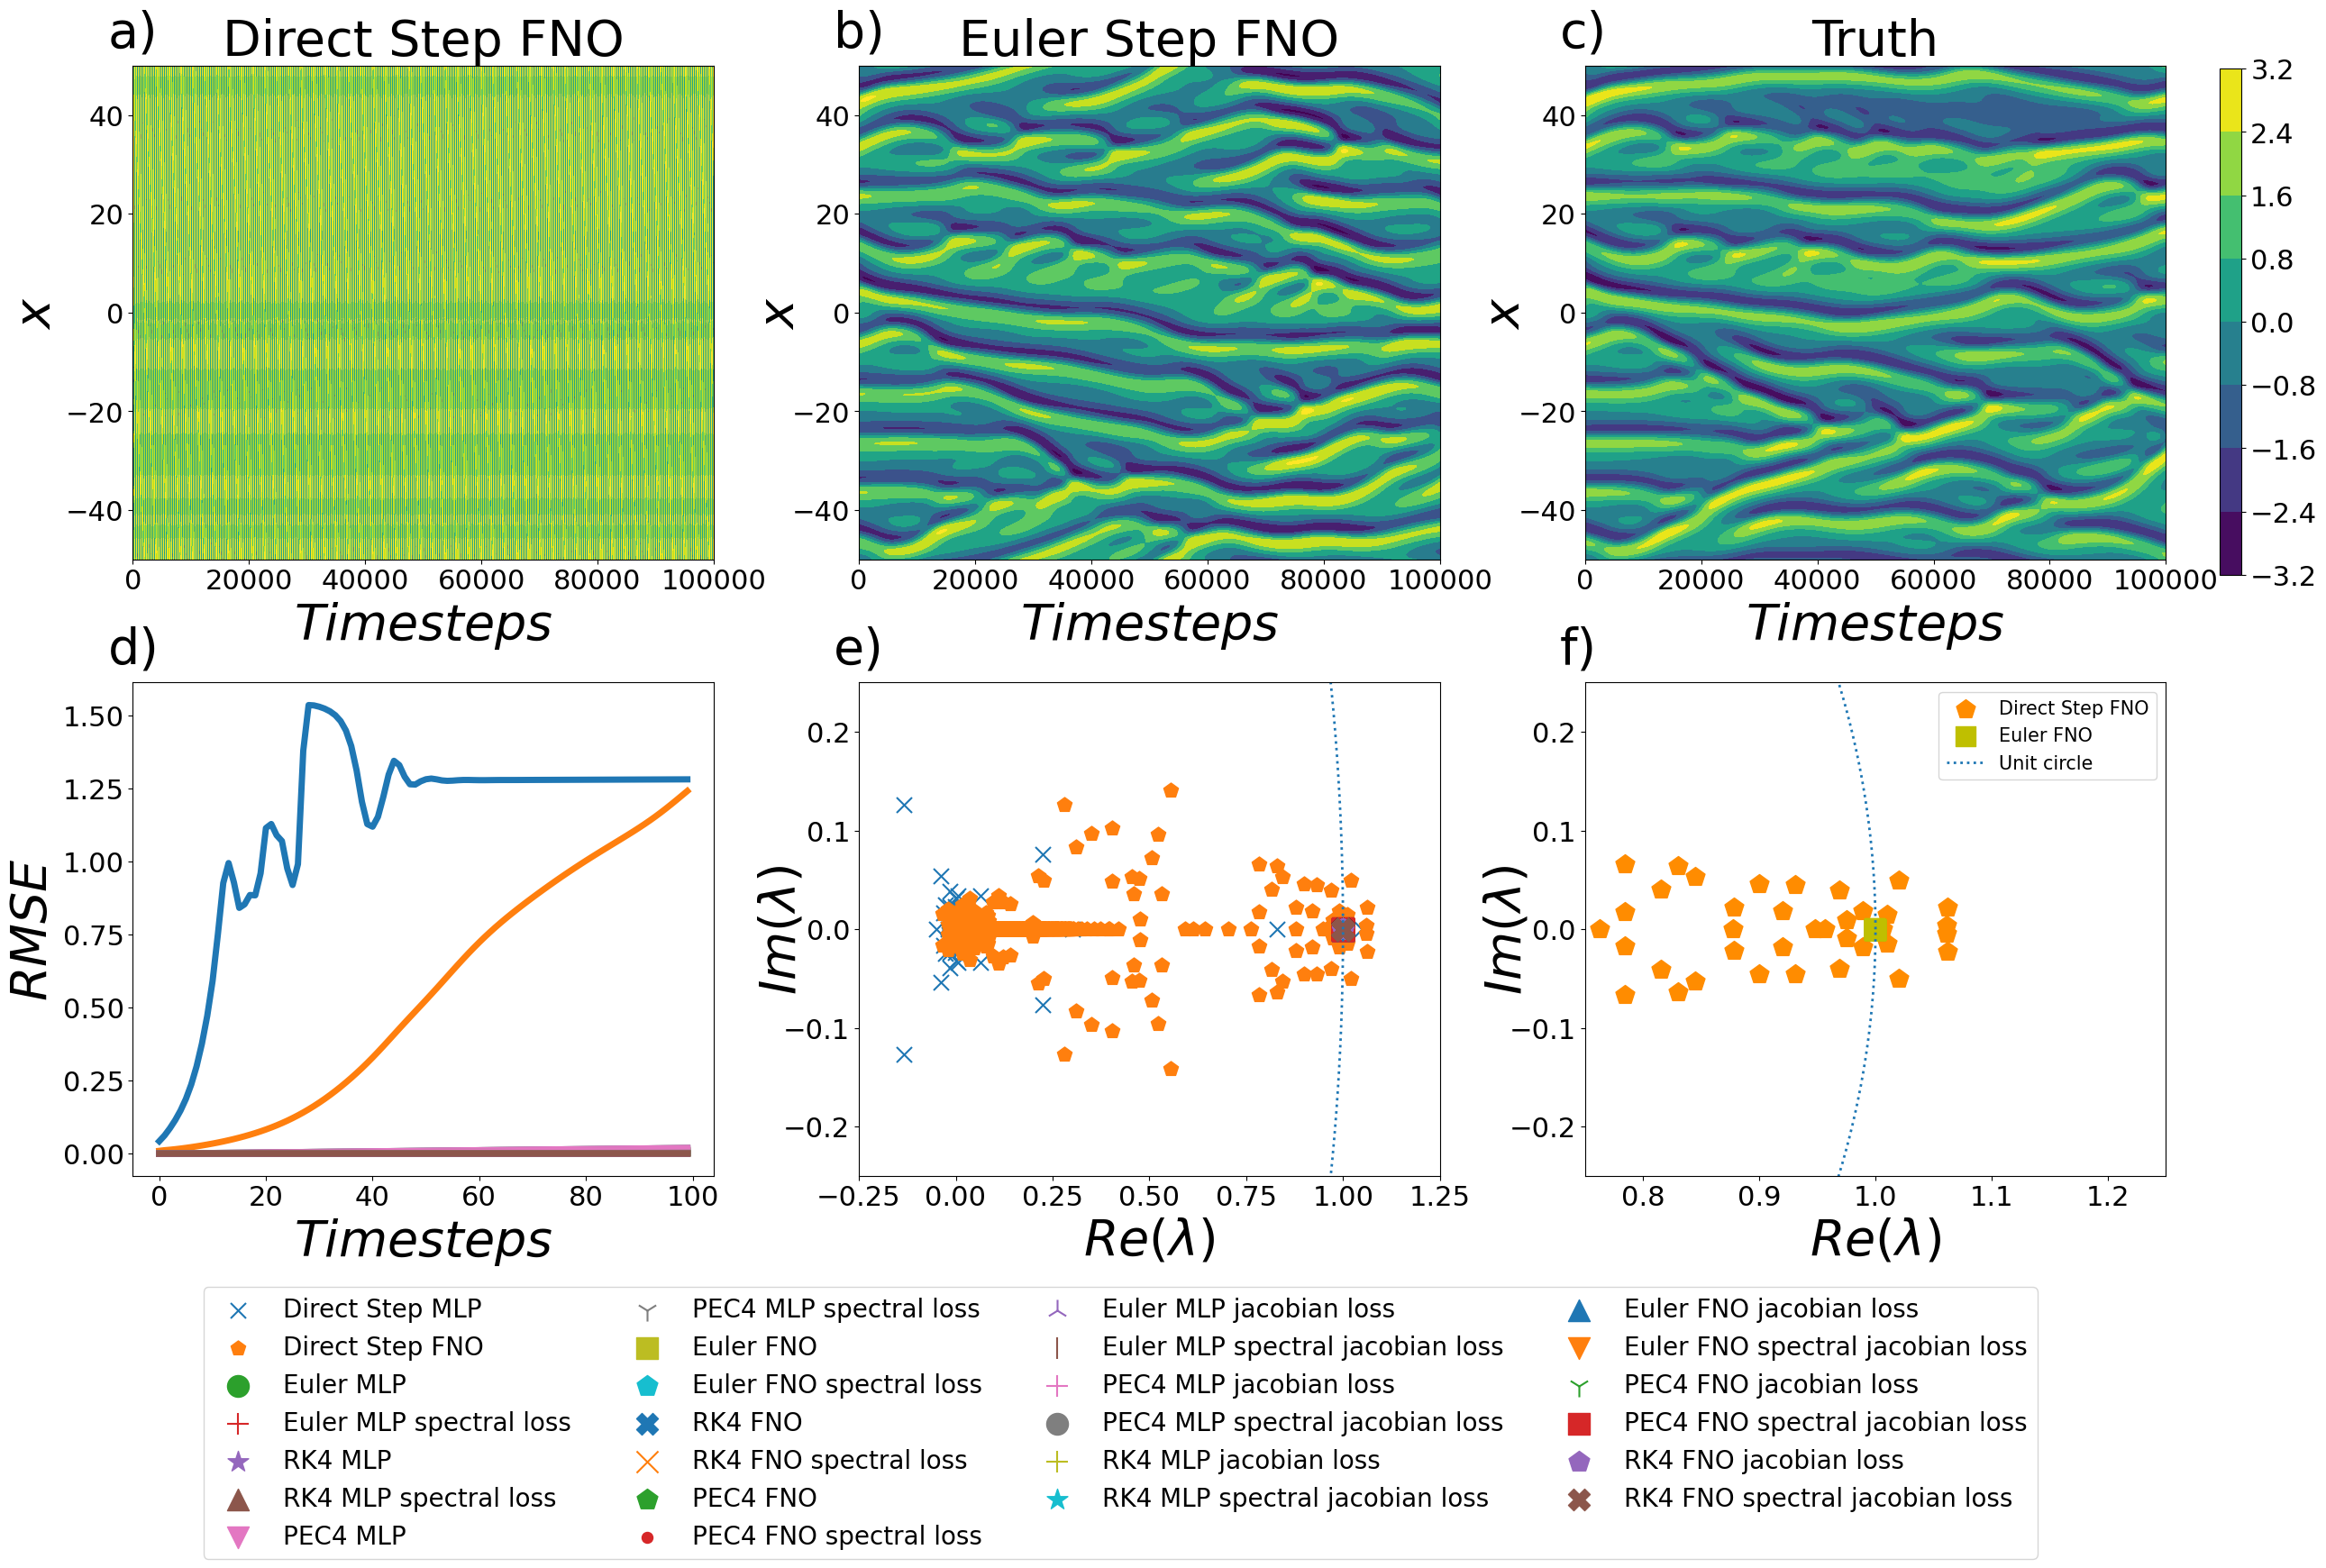

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(24,16))

axs[0, 0].contourf(net_pred[:].T, vmax=3, vmin=-3, extent=[0,100000,-50,50])
axs[0, 0].set_title('Direct Step FNO', fontsize=40)
axs[0, 0].set_xlabel(r'$Timesteps$', fontsize=40)
axs[0, 0].set_ylabel(r'$x$', fontsize=40)
axs[0, 0].xaxis.set_tick_params(labelsize=22)
axs[0, 0].yaxis.set_tick_params(labelsize=22)

axs[0, 1].contourf(net_2_pred[:100000].T, vmax=3, vmin=-3, extent=[0,100000,-50,50])
axs[0, 1].set_title('Euler Step FNO', fontsize=40)
axs[0, 1].set_xlabel(r'$Timesteps$', fontsize=40)
axs[0, 1].set_ylabel(r'$x$', labelpad=-10, fontsize=40)
axs[0, 1].xaxis.set_tick_params(labelsize=22)
axs[0, 1].yaxis.set_tick_params(labelsize=22)

im = axs[0,2].contourf(net_truth[:100000].T, vmax=3, vmin=-3, extent=[0,100000,-50,50])
axs[0,2].set_title('Truth', fontsize=40)
axs[0, 2].set_xlabel(r'$Timesteps$', fontsize=40)
axs[0, 2].set_ylabel(r'$x$', labelpad=-10, fontsize=40)
axs[0, 2].xaxis.set_tick_params(labelsize=22)
axs[0, 2].yaxis.set_tick_params(labelsize=22)

cb_ax = fig.add_axes([.975,.527,.01,.351])
cbar = fig.colorbar(im, orientation='vertical',cax=cb_ax)
cbar.ax.tick_params(labelsize=22) 

trange = 100000
tstart = 0
tend = 100000

for k in range(len(labels)-2, len(labels)):
    axs[1, 0].plot(out_RMSE_vals[k,tstart:tend], label=labels[k], linewidth=5)

for k in range(len(labels)-2):
    axs[1, 0].plot(out_RMSE_vals[k,tstart:tend], label=labels[k], linewidth=5)
# axs[1, 0].legend(bbox_to_anchor=(-.15, 1), prop={'size':7})
# axs[1, 0].set_title('RMSE of all models', fontsize=40)
axs[1, 0].set_xlabel(r'$Timesteps$', fontsize=40)
axs[1, 0].set_ylabel(r'$RMSE$', fontsize=40)
axs[1, 0].xaxis.set_tick_params(labelsize=22)
axs[1, 0].yaxis.set_tick_params(labelsize=22)

axs[1, 2].scatter(net_eigvals.real, net_eigvals.imag, marker='p', color='darkorange', s=250)
axs[1, 2].scatter(net_2_eigvals.real, net_2_eigvals.imag, marker=markers[6], color='y', s=250)
t = np.linspace(0,np.pi*2,10000)
axs[1, 2].plot(np.cos(t), np.sin(t), ':', linewidth=2)
axs[1, 2].set_xlim([.75,1.25])
axs[1, 2].set_ylim([-.25,.25])
axs[1, 2].legend(['Direct Step FNO','Euler FNO','Unit circle '], loc='upper right', prop={'size':15})
# axs[1, 2].set_title('Eigevalues on complex plane', fontsize=40)
axs[1, 2].set_xlabel(r'$Re(\lambda)$', fontsize=40)
axs[1, 2].set_ylabel(r'$Im(\lambda)$', labelpad=-18, fontsize=40)
axs[1, 2].xaxis.set_tick_params(labelsize=22)
axs[1, 2].yaxis.set_tick_params(labelsize=22)

for i in range(len(labels)-2, len(labels)):
    axs[1, 1].scatter(net_eigvals_all[i].real, net_eigvals_all[i].imag, marker=markers[i], label=labels[i], s=150)

for i in range(len(labels)-2):
    axs[1, 1].scatter(net_eigvals_all[i].real, net_eigvals_all[i].imag, marker=markers[i], label=labels[i], s=300)
axs[1, 1].plot(np.cos(t), np.sin(t), ':', linewidth=2)
# axs[1, 1].legend(bbox_to_anchor=(1.05, 1), prop={'size':60})
axs[1, 1].set_xlim([-.25,1.25])
axs[1, 1].set_ylim([-.25,.25])
# axs[1, 1].set_title('Every models Eigevalues', fontsize=40)
axs[1, 1].set_xlabel(r'$Re(\lambda)$', fontsize=40)
axs[1, 1].set_ylabel(r'$Im(\lambda)$', labelpad=-18, fontsize=40)
axs[1, 1].xaxis.set_tick_params(labelsize=22)
axs[1, 1].yaxis.set_tick_params(labelsize=22)

letters = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for indx, ax in enumerate(axs.flat):
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    ax.text(
        0.0, 1.0, letters[indx], transform=(
            ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize='40', va='bottom')

axs[1, 1].legend(loc='upper center', bbox_to_anchor=(0.45, -0.2), ncol=4, prop={'size':20})
plt.subplots_adjust(left=0.01, right=0.95, wspace=0.25, hspace=0.25)


# plt.tight_layout()
fig.savefig('Figure_1.png', dpi=fig.dpi, bbox_inches='tight')

In [19]:
trange = 99999
# with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_full/KS_pred_Eulerstep_FNO_tendency.npy', 'rb') as f: #change based on eval data location.
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Implicit_Eulerstep_FNO_jacs_many_timesteps_lead_50_v2.npy', 'rb') as f: #change based on eval data location.
    data_dict = np.load(f, allow_pickle=True)
net_pred = data_dict.item()['prediction']
net_truth = data_dict.item()['Truth']
net_RMSE  = data_dict.item()['RMSE']
# net_RMSE = np.sqrt(np.mean((net_pred[0:trange] - net_truth[1:trange+1])**2, axis=1) )
# net_FFT_x = data_dict.item()['pred_FFT_x']
net_jacs = data_dict.item()['Jacobians']
# net_pred_from_truch = data_dict.item()['Pred_from_Truth']
# net_truth_indices = data_dict.item()['Truth_indices']
net_eigvals, net_eigvecs = np.linalg.eig(net_jacs[0])


with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Implicit_Eulerstep_FNO_jacs_many_timesteps_lead_100_v2.npy', 'rb') as f: #change based on eval data location.
    data_dict_2 = np.load(f, allow_pickle=True)
net_2_pred = data_dict_2.item()['prediction']
net_2_truth = data_dict.item()['Truth']
net_2_RMSE  = data_dict_2.item()['RMSE']
# net_2_RMSE = np.sqrt(np.mean((net_2_pred[0:trange] - net_truth[1:trange+1])**2, axis=1) )

# net_2_FFT_x = data_dict_2.item()['pred_FFT_x']
net_2_jacs = data_dict_2.item()['Jacobians']
net_2_eigvals, net_2_eigvecs = np.linalg.eig(net_2_jacs[0])

print('1')
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_jacs_many_timesteps_lead_50.npy', 'rb') as f: #change based on eval data location.
# with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_MLP_test_loss_jacs_many_timesteps.npy', 'rb') as f: #change based on eval data location.
    data_dict_3 = np.load(f, allow_pickle=True)
net_3_pred = data_dict_3.item()['prediction']
net_3_truth = data_dict.item()['Truth']
net_3_RMSE  = data_dict_3.item()['RMSE']
# net_3_RMSE = np.sqrt(np.mean((net_3_pred[0:trange] - net_truth[1:trange+1])**2, axis=1) )

# net_3_FFT_x = data_dict_3.item()['pred_FFT_x']
net_3_jacs = data_dict_3.item()['Jacobians']
net_3_eigvals, net_3_eigvecs = np.linalg.eig(net_3_jacs[0])

print('2')
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_jacs_many_timesteps_lead_100.npy', 'rb') as f: #change based on eval data location.
# with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_MLP_spectral_jac_loss_jacs_many_timesteps.npy', 'rb') as f: #change based on eval data location.
    data_dict_4 = np.load(f, allow_pickle=True)
net_4_pred = data_dict_4.item()['prediction']
net_4_truth = data_dict.item()['Truth']
net_4_RMSE  = data_dict_4.item()['RMSE']
# net_4_RMSE = np.sqrt(np.mean((net_4_pred[0:trange] - net_truth[1:trange+1])**2, axis=1) )

# net_4_FFT_x = data_dict_4.item()['pred_FFT_x']
net_4_jacs = data_dict_4.item()['Jacobians']
net_4_eigvals, net_4_eigvecs = np.linalg.eig(net_4_jacs[0])

with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_jacs_many_timesteps.npy', 'rb') as f: #change based on eval data location.
# with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_MLP_spectral_jac_loss_jacs_many_timesteps.npy', 'rb') as f: #change based on eval data location.
    data_dict_5 = np.load(f, allow_pickle=True)
net_5_pred = data_dict_5.item()['prediction']
net_5_RMSE  = data_dict_5.item()['RMSE']
# net_5_RMSE = np.sqrt(np.mean((net_5_pred[0:trange] - net_truth[1:trange+1])**2, axis=1) )

# net_5_FFT_x = data_dict_5.item()['pred_FFT_x']
net_5_jacs = data_dict_5.item()['Jacobians']
net_5_eigvals, net_5_eigvecs = np.linalg.eig(net_5_jacs[0])


with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_implicit_FNO_jacs_many_timesteps_lead_1.npy', 'rb') as f: #change based on eval data location.
# with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_MLP_spectral_jac_loss_jacs_many_timesteps.npy', 'rb') as f: #change based on eval data location.
    data_dict_6 = np.load(f, allow_pickle=True)
net_6_pred = data_dict_6.item()['prediction']
net_6_RMSE  = data_dict_6.item()['RMSE']
# net_6_RMSE = np.sqrt(np.mean((net_6_pred[0:trange] - net_truth[1:trange+1])**2, axis=1) )

# net_6_FFT_x = data_dict_6.item()['pred_FFT_x']
net_6_jacs = data_dict_6.item()['Jacobians']
net_6_eigvals, net_6_eigvecs = np.linalg.eig(net_6_jacs[0])




1
2


In [45]:
print(np.abs(net_eigvals).max(),'I50')
print(np.abs(net_2_eigvals).max(),'I100')
print(np.abs(net_3_eigvals).max(),'E50')
print(np.abs(net_4_eigvals).max(),'E100')
print(np.abs(net_5_eigvals).max(),'E1')
print(np.abs(net_6_eigvals).max(),'I1')


1.0090102 I50
1.0189834 I100
1.0078741 E50
1.0246422 E100
1.0002015 E1
1.0001768 I1


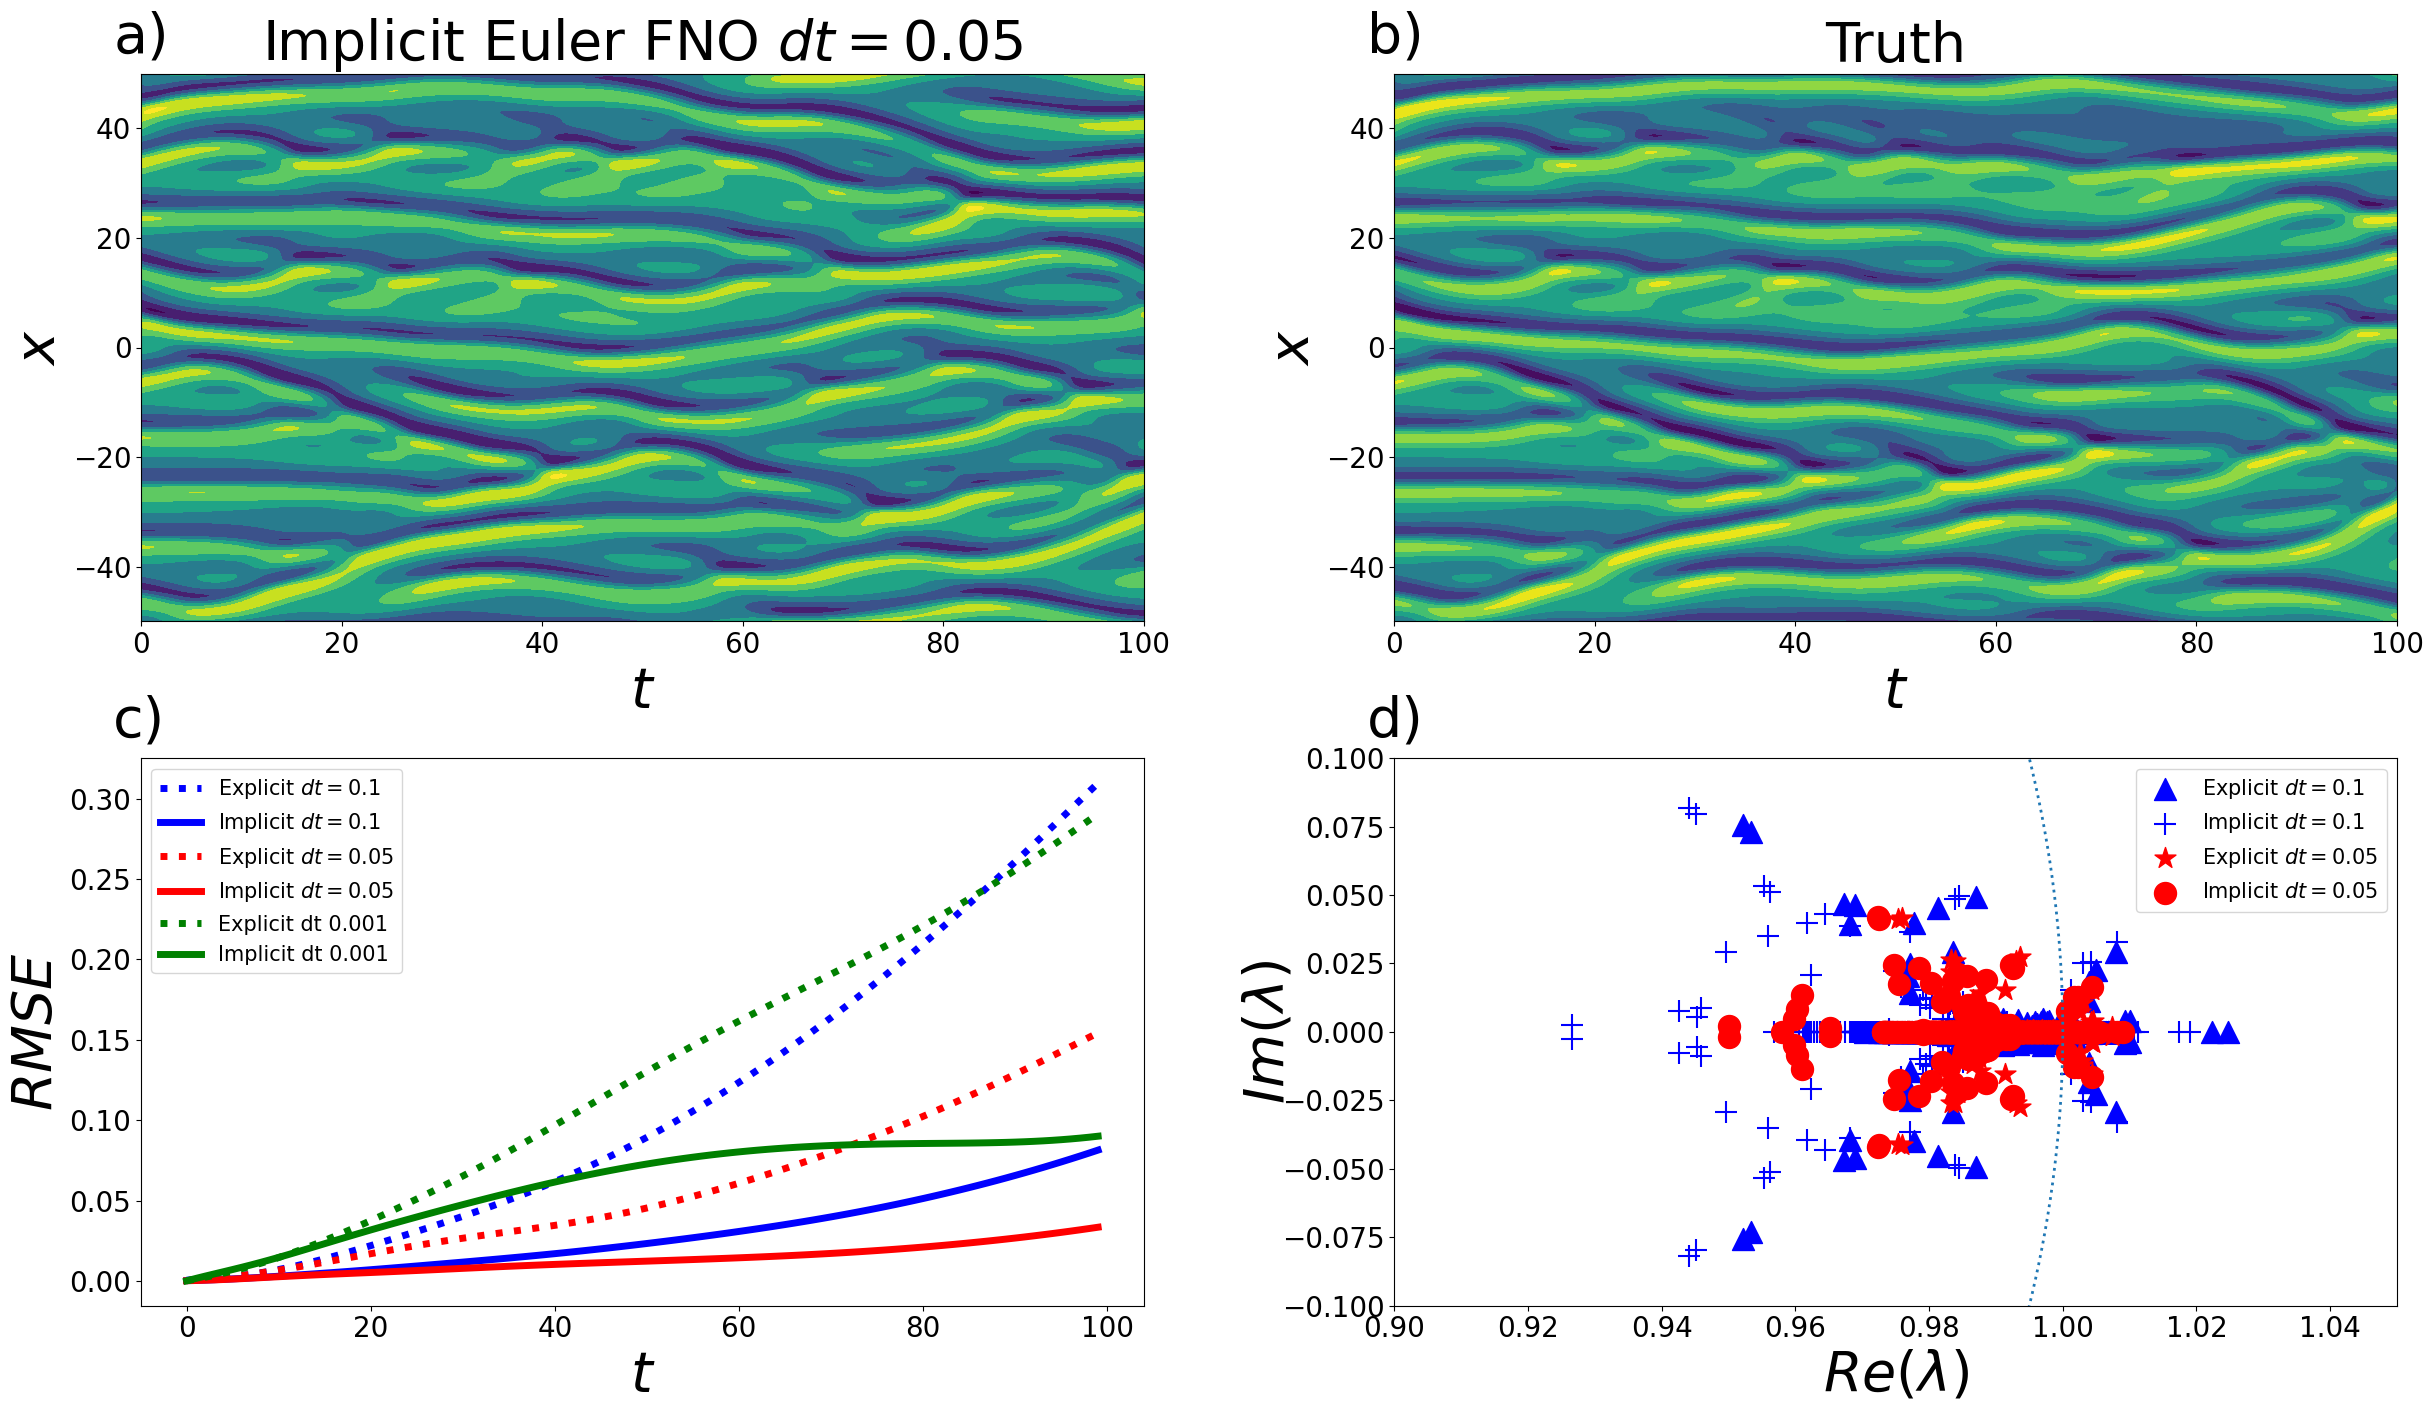

In [20]:
fig, axs = plt.subplots(2,2, figsize=(24, 16))
tstart = 0
tend = 100
trange=1000000

axs[0, 0].contourf(net_pred[:trange].T, vmax=3, vmin=-3, extent=[0,100,-50,50])
axs[0, 0].set_title(r'Implicit Euler FNO $dt=0.05$', fontsize=40)
axs[0, 0].set_xlabel(r'$t$', fontsize=40)
axs[0, 0].set_ylabel(r'$x$', fontsize=40)

axs[0, 0].xaxis.set_tick_params(labelsize=20)
axs[0, 0].yaxis.set_tick_params(labelsize=20)



# axs[0, 1].set_title('Explicit Euler FNO dt 0.05', fontsize=40)
# axs[0, 1].contourf(net_3_pred[:trange].T, vmax=3, vmin=-3, extent=[0,10,0,1024])
# axs[0, 1].set_xlabel(r'$t$', fontsize=40)
# axs[0, 1].set_ylabel(r'$x$', fontsize=40)

axs[0, 1].set_title('Truth', fontsize=40)
axs[0, 1].contourf(test[:trange].T, vmax=3, vmin=-3, extent=[0,100,-50,50])
axs[0, 1].set_xlabel(r'$t$', fontsize=40)
axs[0, 1].set_ylabel(r'$x$', fontsize=40)
axs[0, 1].xaxis.set_tick_params(labelsize=20)
axs[0, 1].yaxis.set_tick_params(labelsize=20)


axs[1, 0].plot(net_4_RMSE[tstart:tend:],':', label=r'Explicit $dt=0.1$', linewidth=5, color='Blue')
axs[1, 0].plot(net_2_RMSE[tstart:tend:], label=r'Implicit $dt=0.1$', linewidth=5, color='Blue')
axs[1, 0].plot(net_3_RMSE[tstart:tend*2:2],':', label=r'Explicit $dt=0.05$', linewidth=5, color='Red')
axs[1, 0].plot(net_RMSE[tstart:tend*2:2], label=r'Implicit $dt=0.05$', linewidth=5, color='Red')

axs[1, 0].plot(net_5_RMSE[tstart:tend*100:100],':', label='Explicit dt 0.001', linewidth=5, color='Green')
axs[1, 0].plot(net_6_RMSE[tstart:tend*100:100], label='Implicit dt 0.001', linewidth=5, color='Green')


# axs[1, 0].set_title('RMSE of Methods')
axs[1, 0].set_xlabel(r'$t$', fontsize=40)
axs[1, 0].set_ylabel(r'$RMSE$', fontsize=40)
axs[1, 0].legend(prop={'size':15})
locs = np.linspace(tstart,tend/100, 6, dtype=int)
# locs *= 1000
# axs[1, 0].set_xticks(locs, labels)

axs[1, 0].xaxis.set_tick_params(labelsize=20)
axs[1, 0].yaxis.set_tick_params(labelsize=20)

# residuals = net_truth[0:2] - net_pred[0:2]
# residuals_2 = net_2_truth[0:2] - net_2_pred[0:2]
# residuals_3 = net_3_truth[0:2] - net_3_pred[0:2]
# residuals_4 = net_4_truth[0:2] - net_4_pred[0:2]

# res_1 = np.linalg.norm(residuals[1:2], axis=1)[0] / np.linalg.norm(residuals[0:1], axis=1)[0]
# res_2 = np.linalg.norm(residuals_2[1:2], axis=1)[0] / np.linalg.norm(residuals_2[0:1], axis=1)[0]
# res_3 = np.linalg.norm(residuals_3[1:2], axis=1)[0] / np.linalg.norm(residuals_3[0:1], axis=1)[0]
# res_4 = np.linalg.norm(residuals_4[1:2], axis=1)[0] / np.linalg.norm(residuals_4[0:1], axis=1)[0]

# axs[1, 1].bar(0, (res_1)/np.abs(net_eigvals).max())
# axs[1, 1].bar(1, (res_3)/np.abs(net_3_eigvals).max())
# axs[1, 1].bar(2, (res_2)/np.abs(net_2_eigvals).max())
# axs[1, 1].bar(3, (res_4)/np.abs(net_4_eigvals).max())


# axs[1, 1].scatter(np.linalg.norm(residuals[0:1], axis=1)[0] * np.abs(net_eigvals).max(), np.linalg.norm(residuals[1:2], axis=1)[0], label='i dt 50')
# axs[1, 1].scatter(np.linalg.norm(residuals_2[0:1], axis=1)[0] * np.abs(net_2_eigvals).max(), np.linalg.norm(residuals_2[1:2], axis=1)[0], label='i dt 100')
# axs[1, 1].scatter(np.linalg.norm(residuals_3[0:1], axis=1)[0] * np.abs(net_3_eigvals).max(), np.linalg.norm(residuals_3[1:2], axis=1)[0], label='e dt 50')
# axs[1, 1].scatter(np.linalg.norm(residuals_4[0:1], axis=1)[0] * np.abs(net_4_eigvals).max(), np.linalg.norm(residuals_4[1:2], axis=1)[0], label='e dt 100')
# axs[1,1].legend()

# axs[1, 1].set_xticks([0,1,2,3],['Implicit 0.05','Explicit 0.05 ','Implicit 0.1', 'Explicit 0.1'])
# axs[1, 1].set_ylim([1,2.25])
# axs[1, 1].set_ylabel(r'$\frac{||e(t+1)||}{||e(t)|| \lambda_{max} }$', fontsize=40)
# axs[1, 1].xaxis.set_tick_params(labelsize=20)
# axs[1, 1].yaxis.set_tick_params(labelsize=20)

axs[1, 1].scatter(net_4_eigvals.real, net_4_eigvals.imag, marker=markers[3], label=r'Explicit $dt=0.1$', s=250, color='Blue')
axs[1, 1].scatter(net_2_eigvals.real, net_2_eigvals.imag, marker=markers[1], label=r'Implicit $dt=0.1$', s=250, color='Blue')
axs[1, 1].scatter(net_3_eigvals.real, net_3_eigvals.imag, marker=markers[2], label=r'Explicit $dt=0.05$', s=250, color='Red')
axs[1, 1].scatter(net_eigvals.real, net_eigvals.imag, marker=markers[0], label=r'Implicit $dt=0.05$', s=250, color='Red')

t = np.linspace(0,np.pi*2,10000)
axs[1, 1].plot(np.cos(t), np.sin(t), ':', linewidth=2)
axs[1, 1].legend( prop={'size':15})
axs[1, 1].set_xlim([.9, 1.05])
axs[1, 1].set_ylim([-.1,.1])
# axs[1, 1].set_title('Every models Eigevalues', fontsize=40)
axs[1, 1].set_xlabel(r'$Re(\lambda)$', fontsize=40)
axs[1, 1].set_ylabel(r'$Im(\lambda)$', labelpad=-10, fontsize=40)
axs[1, 1].xaxis.set_tick_params(labelsize=20)
axs[1, 1].yaxis.set_tick_params(labelsize=20)


letters = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for indx, ax in enumerate(axs.flat):
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    ax.text(
        0.0, 1.0, letters[indx], transform=(
            ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize='40', va='bottom')
plt.subplots_adjust(left=0.01, right=0.95, wspace=0.25, hspace=0.25)


fig.savefig('Figure_3.png', dpi=fig.dpi, bbox_inches='tight')

In [27]:
trange = 99999
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_full/KS_pred_Directstep_FNO.npy', 'rb') as f: #change based on eval data location.
    data_dict = np.load(f, allow_pickle=True)
net_pred = data_dict.item()['prediction']
net_truth = data_dict.item()['Truth']
net_RMSE  = data_dict.item()['RMSE']
net_FFT_x = data_dict.item()['pred_FFT_x']
net_jacs = data_dict.item()['Jacobians']
# net_pred_from_truch = data_dict.item()['Pred_from_Truth']
# net_truth_indices = data_dict.item()['Truth_indices']
net_eigvals, net_eigvecs = np.linalg.eig(net_jacs[0])

with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_full/KS_pred_Directstep_MLP.npy', 'rb') as f: #change based on eval data location.
    data_dict_8 = np.load(f, allow_pickle=True)
net_8_pred = data_dict_8.item()['prediction']
net_8_RMSE  = data_dict_8.item()['RMSE']
net_8_FFT_x = data_dict_8.item()['pred_FFT_x']
net_8_jacs = data_dict_8.item()['Jacobians']
net_8_eigvals, net_8_eigvecs = np.linalg.eig(net_8_jacs[0])


with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_full/KS_pred_Eulerstep_FNO_tendency.npy', 'rb') as f: #change based on eval data location.
    data_dict_2 = np.load(f, allow_pickle=True)
net_2_pred = data_dict_2.item()['prediction']
net_2_truth = data_dict.item()['Truth']
net_2_RMSE  = data_dict_2.item()['RMSE']
net_2_FFT_x = data_dict_2.item()['pred_FFT_x']
net_2_jacs = data_dict_2.item()['Jacobians']
net_2_eigvals, net_2_eigvecs = np.linalg.eig(net_2_jacs[0])

print('1')
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_full/KS_pred_PEC4step_FNO_tendency.npy', 'rb') as f: #change based on eval data location.
    data_dict_3 = np.load(f, allow_pickle=True)
net_3_pred = data_dict_3.item()['prediction']
net_3_truth = data_dict.item()['Truth']
net_3_RMSE  = data_dict_3.item()['RMSE']
net_3_FFT_x = data_dict_3.item()['pred_FFT_x']
net_3_jacs = data_dict_3.item()['Jacobians']
net_3_eigvals, net_3_eigvecs = np.linalg.eig(net_3_jacs[0])

print('2')
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_full/KS_pred_RK4step_FNO_tendency.npy', 'rb') as f: #change based on eval data location.
    data_dict_4 = np.load(f, allow_pickle=True)
net_4_pred = data_dict_4.item()['prediction']
net_4_truth = data_dict.item()['Truth']
net_4_RMSE  = data_dict_4.item()['RMSE']
net_4_FFT_x = data_dict_4.item()['pred_FFT_x']
net_4_jacs = data_dict_4.item()['Jacobians']
net_4_eigvals, net_4_eigvecs = np.linalg.eig(net_4_jacs[0])

with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_full/KS_pred_Eulerstep_MLP_tendency.npy', 'rb') as f: #change based on eval data location.
    data_dict_5 = np.load(f, allow_pickle=True)
net_5_pred = data_dict_5.item()['prediction']
net_5_RMSE  = data_dict_5.item()['RMSE']
net_5_FFT_x = data_dict_5.item()['pred_FFT_x']
net_5_jacs = data_dict_5.item()['Jacobians']
net_5_eigvals, net_5_eigvecs = np.linalg.eig(net_5_jacs[0])

with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_full/KS_pred_PEC4step_MLP_tendency.npy', 'rb') as f: #change based on eval data location.
    data_dict_6 = np.load(f, allow_pickle=True)
net_6_pred = data_dict_6.item()['prediction']
net_6_RMSE  = data_dict_6.item()['RMSE']
net_6_FFT_x = data_dict_6.item()['pred_FFT_x']
net_6_jacs = data_dict_6.item()['Jacobians']
net_6_eigvals, net_6_eigvecs = np.linalg.eig(net_6_jacs[0])

with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_full/KS_pred_RK4step_MLP_tendency.npy', 'rb') as f: #change based on eval data location.
    data_dict_7 = np.load(f, allow_pickle=True)
net_7_pred = data_dict_7.item()['prediction']
net_7_RMSE  = data_dict_7.item()['RMSE']
net_7_FFT_x = data_dict_7.item()['pred_FFT_x']
net_7_jacs = data_dict_7.item()['Jacobians']
net_7_eigvals, net_7_eigvecs = np.linalg.eig(net_7_jacs[0])

1
2


In [ ]:
fig, axs = plt.subplots(2,2, figsize=(24, 16))
tstart = 0
tend = 4999
f_spec_truth = np.abs(np.fft.rfft(net_truth))
val_1 = np.sqrt(np.mean((np.real(net_FFT_x[tstart:tend,:513]) - f_spec_truth[tstart:tend])**2, axis=1))
val_2 = np.sqrt(np.mean((np.real(net_2_FFT_x[tstart:tend,:513]) - f_spec_truth[tstart:tend])**2, axis=1))
val_3 = np.sqrt(np.mean((np.real(net_3_FFT_x[tstart:tend,:513]) - f_spec_truth[tstart:tend])**2, axis=1))
val_4 = np.sqrt(np.mean((np.real(net_4_FFT_x[tstart:tend,:513]) - f_spec_truth[tstart:tend])**2, axis=1))
val_5 = np.sqrt(np.mean((np.real(net_5_FFT_x[tstart:tend,:513]) - f_spec_truth[tstart:tend])**2, axis=1))
val_6 = np.sqrt(np.mean((np.real(net_6_FFT_x[tstart:tend,:513]) - f_spec_truth[tstart:tend])**2, axis=1))
val_7 = np.sqrt(np.mean((np.real(net_7_FFT_x[tstart:tend,:513]) - f_spec_truth[tstart:tend])**2, axis=1))
val_8 = np.sqrt(np.mean((np.real(net_8_FFT_x[tstart:tend,:513]) - f_spec_truth[tstart:tend])**2, axis=1))

axs[0,0].plot(val_8, ':', label='Direct Step MLP', linewidth=5)
axs[0,0].plot(val_1, label='Direct Step FNO', linewidth=5)
axs[0,0].plot(val_5, ':', label='Euler MLP w/ spectral loss', linewidth=5)
axs[0,0].plot(val_6, ':', label='PEC4 MLP w/ spectral loss', linewidth=5)
axs[0,0].plot(val_7, ':', label='RK4 MLP w/ spectral loss', linewidth=5)
axs[0,0].plot(val_2, label='Euler FNO w/ spectral loss', linewidth=5)
axs[0,0].plot(val_3, label='PEC4 FNO w/ spectral loss', linewidth=5)
axs[0,0].plot(val_4, label='RK4 FNO w/ spectral loss', linewidth=5)
axs[0, 0].legend(loc='upper center', prop={'size':15})

# axs[0, 0].set_title('Spectrum RMSE', fontsize=40)
axs[0, 0].set_xlabel(r'$Timesteps$', fontsize=40)
axs[0, 0].set_ylabel(r'$RMSE(|\hat{u}|)$', fontsize=40)

axs[0, 0].xaxis.set_tick_params(labelsize=20)
axs[0, 0].yaxis.set_tick_params(labelsize=20)

# axs[0, 1].scatter(net_8_eigvals.real, net_8_eigvals.imag, marker=markers[3], label='Directstep MLP', s=100)
# axs[0, 1].scatter(net_eigvals.real, net_eigvals.imag, marker=markers[0], label='Direct FNO', s=100)
# axs[0, 1].scatter(net_5_eigvals.real, net_5_eigvals.imag, marker=markers[3], label='Eulerstep MLP w/ spectral loss', s=100)
# axs[0, 1].scatter(net_6_eigvals.real, net_6_eigvals.imag, marker=markers[3], label='PEC4step MLP w/ spectral loss', s=100)
# axs[0, 1].scatter(net_7_eigvals.real, net_7_eigvals.imag, marker=markers[3], label='RK4step MLP w/ spectral loss', s=100)
# axs[0, 1].scatter(net_2_eigvals.real, net_2_eigvals.imag, marker=markers[1], label='Eulerstep FNO w/ spectral loss', s=100)
# axs[0, 1].scatter(net_3_eigvals.real, net_3_eigvals.imag, marker=markers[2], label='PEC4step FNO w/ spectral loss', s=100)
# axs[0, 1].scatter(net_4_eigvals.real, net_4_eigvals.imag, marker=markers[3], label='RK4step FNO w/ spectral loss', s=100)

# t = np.linspace(0,np.pi*2,10000)
# axs[0, 1].plot(np.cos(t), np.sin(t), ':', linewidth=2)
# axs[0, 1].legend(bbox_to_anchor=(1.0, 1), prop={'size':7})
# axs[0, 1].set_xlim([.9, 1.1])
# axs[0, 1].set_ylim([-.2,.2])
# # axs[0, 1].set_title('Every models Eigevalues', fontsize=40)
# axs[0, 1].set_xlabel(r'$Re(\lambda)$', fontsize=40)
# axs[0, 1].set_ylabel(r'$Im(\lambda)$', fontsize=40)
# axs[0, 1].xaxis.set_tick_params(labelsize=20)
# axs[0, 1].yaxis.set_tick_params(labelsize=20)

axs[0, 1].scatter(net_6_eigvals.real, net_6_eigvals.imag, marker=markers[0], label='PEC4 MLP w/ spectral loss', s=250)
axs[0, 1].scatter(net_3_eigvals.real, net_3_eigvals.imag, marker=markers[2], label='PEC4 FNO w/ spectral loss', s=250)
t = np.linspace(0,np.pi*2,10000)
axs[0, 1].plot(np.cos(t), np.sin(t), ':', linewidth=2)
axs[0, 1].legend(prop={'size':20})
axs[0, 1].set_xlim([.999, 1.001])
axs[0, 1].set_ylim([-.001,.001])
# axs[0, 1].set_title('Model Eigevalues', fontsize=40)
axs[0, 1].set_xlabel(r'$Re(\lambda)$', fontsize=40)
axs[0, 1].set_ylabel(r'$Im(\lambda)$', fontsize=40)
axs[0, 1].xaxis.set_tick_params(labelsize=20)
axs[0, 1].yaxis.set_tick_params(labelsize=20)
axs[0, 1].ticklabel_format(axis='y', style='sci', scilimits=(-2,-1))
axs[0, 1].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[0, 1].ticklabel_format(useOffset=False, style='plain')

axs[1,0].loglog(np.real(net_6_FFT_x[0,:513]) , label='PEC4 MLP w/ spectral loss')
axs[1,0].loglog(np.real(net_3_FFT_x[0,:513]) , label='PEC4 FNO w/ spectral loss')
axs[1,0].loglog(f_spec_truth[0] , ':', label='Truth')

# axs[1, 0].set_title('Spectrum RMSE', fontsize=40)
axs[1, 0].set_xlabel(r'$\omega$', fontsize=40)
axs[1, 0].set_ylabel(r'$|\hat{u}|$', fontsize=40)

axs[1, 0].xaxis.set_tick_params(labelsize=20)
axs[1, 0].yaxis.set_tick_params(labelsize=20)
# axs[1, 0].set_title('Fourier Spectrum of first time Step')
axs[1, 0].legend(prop={'size':15})

net_6_tendency_spec = np.fft.rfft(np.diff(net_6_pred[0:2], n=1, axis=0))[0]
net_3_tendency_spec = np.fft.rfft(np.diff(net_3_pred[0:2], n=1, axis=0))[0]
truth_tendency_spec = np.fft.rfft(np.diff(net_truth[0:2], n=1, axis=0))[0]

axs[1, 1].loglog(np.abs(net_6_tendency_spec) , label='PEC4 MLP w/ spectral loss')
axs[1, 1].loglog(np.abs(net_3_tendency_spec) , label='PEC4 FNO w/ spectral loss')
axs[1, 1].loglog(np.abs(truth_tendency_spec), ':', label='Truth')

# axs[1, 1].set_title('Spectrum RMSE', fontsize=40)
axs[1, 1].set_xlabel(r'$\omega$', fontsize=40)
axs[1, 1].set_ylabel(r'$\frac{d|\hat{u}|}{dt}$', fontsize=40)

axs[1, 1].xaxis.set_tick_params(labelsize=20)
axs[1, 1].yaxis.set_tick_params(labelsize=20)
# axs[1, 1].set_title('Fourier Spectrum of first timestep')
axs[1, 1].legend(prop={'size':20})

letters = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for indx, ax in enumerate(axs.flat):
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    ax.text(
        0.0, 1.0, letters[indx], transform=(
            ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize='40', va='bottom')
plt.subplots_adjust(left=0.01, right=0.95, wspace=0.25, hspace=0.25)

fig.tight_layout()
fig.savefig('Figure_4.png', dpi=fig.dpi, bbox_inches='tight')

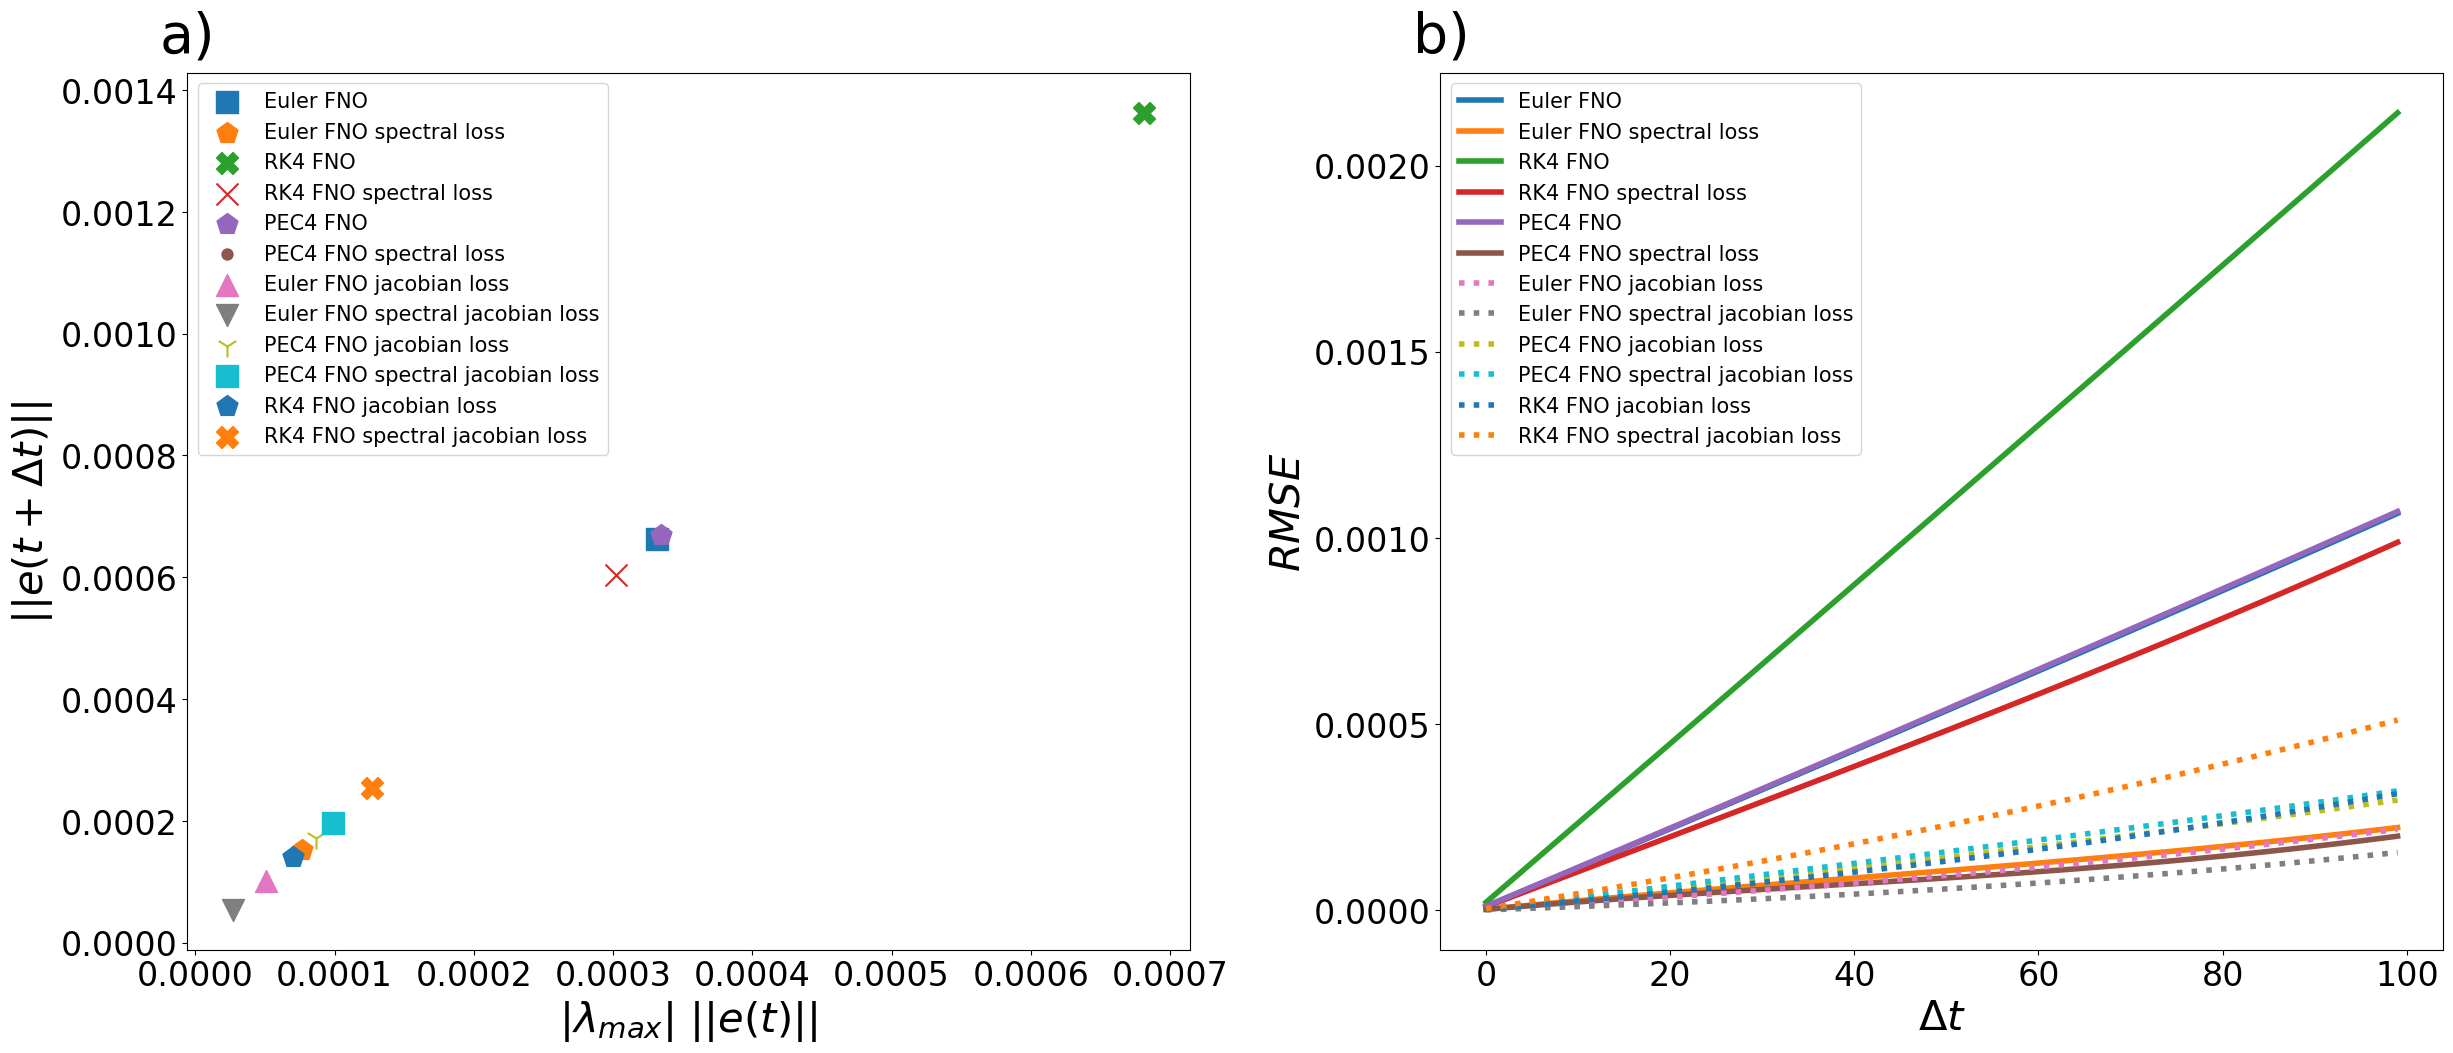

In [38]:
fig, axs = plt.subplots(1,2, figsize=(24, 10))


for i in range(6, 12):
    # print(x_vals[i], y_vals[i], markers[i], labels[i])
    axs[0].scatter(x_vals[i], y_vals[i], marker=markers[i], label=labels[i], s=250)

for i in range(18, len(file_names)-2):
    # print(x_vals[i], y_vals[i], markers[i], labels[i])
    axs[0].scatter(x_vals[i], y_vals[i], marker=markers[i], label=labels[i], s=250)
x = np.linspace(0, 1.5, num=1000)
# plt.plot(x, m_1*x + b_1, label='Best fit directstep')
# axs[0].plot(x, m_2*x + b_2, label='Best fit Numerical int')
axs[0].set_ylabel(r'$||e(t+\Delta t)||$', fontsize=30)
axs[0].set_xlabel(r'$|\lambda_{max}| \  ||e(t)||$', fontsize=30)
axs[0].legend( prop={'size':15})
axs[0].xaxis.set_tick_params(labelsize=24)
axs[0].yaxis.set_tick_params(labelsize=24)
# plt.xscale('log')
# plt.yscale('log')
# axs[0].set_title('Largest Eigevalue and MSE of all methods', fontsize=30)

trange = 100000
tstart = 0
tend = 20
# tend = 100

for k in range(6, 12):
    axs[1].plot(out_RMSE_vals[k,tstart:tend], label=labels[k], linewidth=4)

for k in range(18, len(labels) - 2):
    axs[1].plot(out_RMSE_vals[k,tstart:tend],':', label=labels[k], linewidth=4)
axs[1].legend(prop={'size':15})
# axs[1].set_title('RMSE of all models', fontsize=25)
axs[1].set_xlabel(r'$\Delta t$', fontsize=30)
axs[1].set_ylabel(r'$RMSE$', fontsize=30)
axs[1].xaxis.set_tick_params(labelsize=20)
axs[1].yaxis.set_tick_params(labelsize=20)
axs[1].xaxis.set_tick_params(labelsize=24)
axs[1].yaxis.set_tick_params(labelsize=24)
fig.tight_layout()

letters = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for indx, ax in enumerate(axs.flat):
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    ax.text(
        0.0, 1.0, letters[indx], transform=(
            ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize='40', va='bottom')
plt.subplots_adjust(left=0.01, right=0.95, wspace=0.25, hspace=0.25)

# fig.savefig('Figure_5.png', dpi=fig.dpi, bbox_inches='tight')

In [2]:
trange = 99999
# with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_full/KS_pred_Directstep_FNO.npy', 'rb') as f: #change based on eval data location.
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_FNO_jacs_many_timesteps.npy', 'rb') as f: #change based on eval data location.
    data_dict = np.load(f, allow_pickle=True)
net_pred = data_dict.item()['prediction']
net_truth = data_dict.item()['Truth']
net_RMSE  = data_dict.item()['RMSE']
net_FFT_x = data_dict.item()['pred_FFT_x']
net_jacs = data_dict.item()['Jacobians']
# net_pred_from_truch = data_dict.item()['Pred_from_Truth']
# net_truth_indices = data_dict.item()['Truth_indices']
net_eigvals, net_eigvecs = np.linalg.eig(net_jacs[0])

# with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_full/KS_pred_Directstep_MLP.npy', 'rb') as f: #change based on eval data location.
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_PEC4step_FNO_tendency_jacs_many_timesteps.npy', 'rb') as f: #change based on eval data location.
    data_dict_2 = np.load(f, allow_pickle=True)
net_2_pred = data_dict_2.item()['prediction']
net_2_RMSE  = data_dict_2.item()['RMSE']
net_2_FFT_x = data_dict_2.item()['pred_FFT_x']
net_2_jacs = data_dict_2.item()['Jacobians']
net_2_eigvals, net_2_eigvecs = np.linalg.eig(net_2_jacs[0])

In [3]:
residuals =  net_truth[0:100]  - net_pred[0:100] 
residuals = residuals / np.linalg.norm(residuals, axis=1)[:,None]

residuals_2 = net_truth[0:100] - net_2_pred[0:100]
residuals_2 = residuals_2 / np.linalg.norm(residuals_2, axis=1)[:,None]

# residuals_3 = net_truth[0:100] - net_3_pred[0:100]
# residuals_3 = residuals_3 / np.linalg.norm(residuals_3, axis=1)[:,None]

# residuals_4 = net_truth[0:100] - net_4_pred[0:100]
# residuals_4 = residuals_4 / np.linalg.norm(residuals_4, axis=1)[:,None]

# residuals_5 = net_truth[0:100] - net_5_pred[0:100]
# residuals_5 = residuals_5 / np.linalg.norm(residuals_5, axis=1)[:,None]

# residuals_6 = net_truth[0:100] - net_6_pred[0:100]
# residuals_6 = residuals_6 / np.linalg.norm(residuals_6, axis=1)[:,None]

t_num_jacs = 0
t_num_res = 0
net_eigvals, net_eigvecs = np.linalg.eig(net_jacs[t_num_jacs])
net_eigvals_2, net_eigvecs_2 = np.linalg.eig(net_2_jacs[t_num_jacs])
# net_eigvals_3, net_eigvecs_3 = np.linalg.eig(net_3_jacs[t_num])
# net_eigvals_4, net_eigvecs_4 = np.linalg.eig(net_4_jacs[t_num])
# net_eigvals_5, net_eigvecs_5 = np.linalg.eig(net_5_jacs[t_num])
# net_eigvals_6, net_eigvecs_6 = np.linalg.eig(net_6_jacs[t_num])

cmap = (net_eigvecs.T @ residuals[t_num_res])
cmap_2 = (net_eigvecs_2.T @ residuals_2[t_num_res])
# cmap_3 = (net_eigvecs_3.T @ residuals_3[t_num]).real
# cmap_4 = (net_eigvecs_4.T @ residuals_4[t_num]).real
# cmap_5 = (net_eigvecs_5.T @ residuals_5[t_num]).real
# cmap_6 = (net_eigvecs_6.T @ residuals_6[t_num]).real

t_num_res_t = 99
cmap_t = (net_eigvecs.T @ residuals[t_num_res_t])
cmap_2_t = (net_eigvecs_2.T @ residuals_2[t_num_res_t])

# print(((net_eigvals) @ np.abs(cmap)).real, ((net_eigvals_2) @ np.abs(cmap_2)).real, ((net_eigvals_3) @ np.abs(cmap_3)).real)
# np.linalg.norm(net_jacs[t_num] @ residuals[t_num]), np.linalg.norm(net_2_jacs[t_num] @ residuals_2[t_num]), np.linalg.norm(net_3_jacs[t_num] @ residuals_3[t_num])


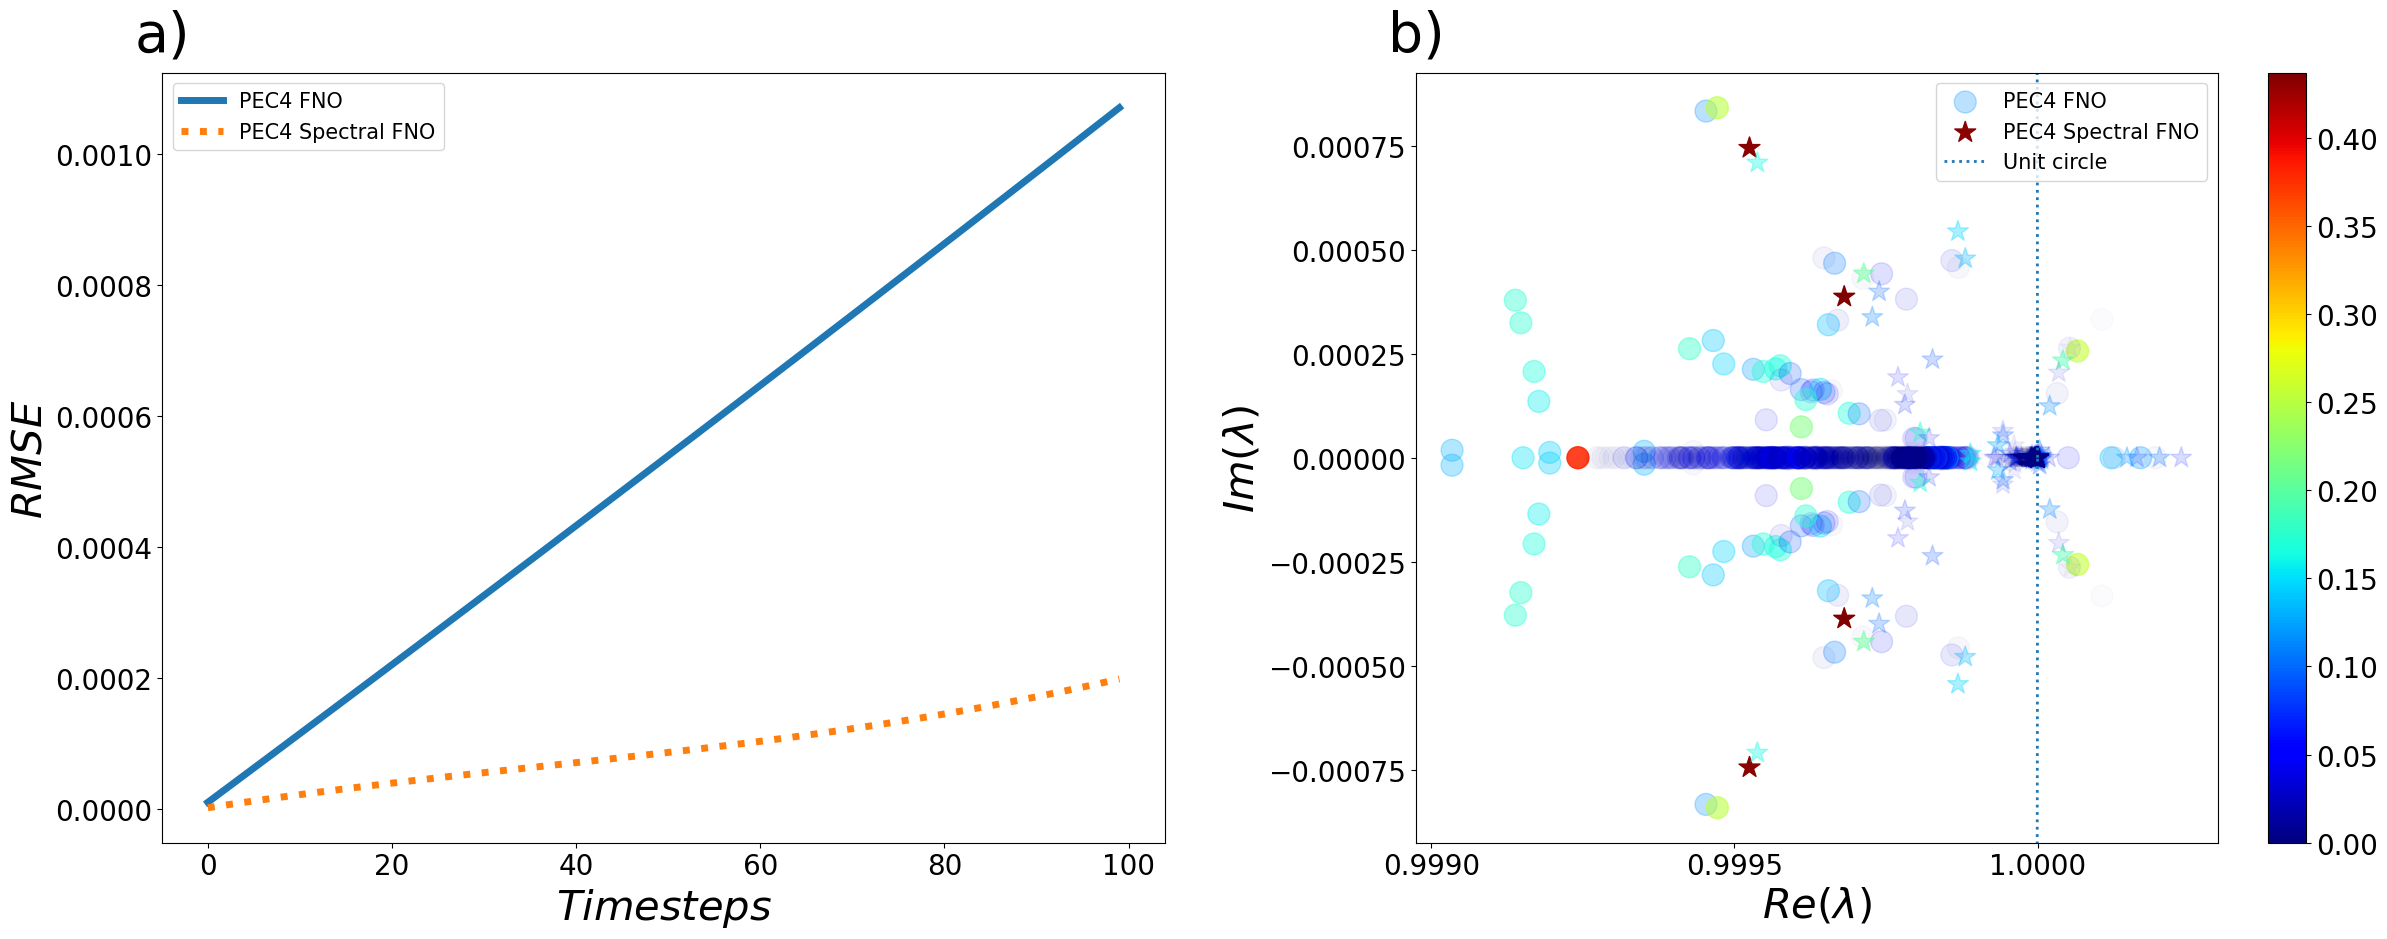

In [13]:
# net_eigvals[np.abs(cmap)<0.1] = 0
# net_eigvals_2[np.abs(cmap_2)<0.1] = 0
# net_eigvals_3[cmap_3<1] = 0
# net_eigvals_4[cmap_3<1] = 0
# net_eigvals_5[cmap_5<1] = 0
# net_eigvals_6[cmap_3<1] = 0
fig, axs = plt.subplots(1, 2, figsize=(24,10))

trange = 100
axs[0].plot(net_RMSE[:trange], label='PEC4 FNO', linewidth=5)
axs[0].plot(net_2_RMSE[:trange], ':', label='PEC4 Spectral FNO', linewidth=5)
axs[0].set_xlabel(r'$Timesteps$', fontsize=30)
axs[0].set_ylabel(r'$RMSE$', fontsize=30)
axs[0].legend( prop={'size':15})
axs[0].xaxis.set_tick_params(labelsize=20)
axs[0].yaxis.set_tick_params(labelsize=20)

norm_colors = colors.Normalize(vmin=0, vmax=max(np.abs(cmap_t.max()), np.abs(cmap_2.max())))

cmap_t_opacities = np.abs(cmap_t)/max(np.abs(cmap_t.max()), np.abs(cmap_2.max()))
cmap_2_opacities = np.abs(cmap_2)/max(np.abs(cmap_t.max()), np.abs(cmap_2.max()))



scat = axs[1].scatter(net_eigvals.real, net_eigvals.imag, c=np.abs(cmap_t), alpha=cmap_t_opacities, norm=norm_colors, cmap = 'jet', s=250)
scat = axs[1].scatter(net_eigvals_2.real, net_eigvals_2.imag, c=np.abs(cmap_2), alpha=cmap_2_opacities, norm=norm_colors, marker='*', cmap = 'jet', s=250)

xlims = axs[1].get_xlim()
ylims = axs[1].get_ylim()
# xlims = [0.9999, 1.0003]
# ylims = [-0.0004, 0.0004]
t = np.linspace(0,np.pi*2,10000)
axs[1].plot(np.cos(t), np.sin(t), ':', linewidth=2)
axs[1].set_xlim(xlims)
axs[1].set_ylim(ylims)
axs[1].legend(['PEC4 FNO','PEC4 Spectral FNO','Unit circle '], loc='upper right', prop={'size':15})
cbar = fig.colorbar(scat, ax = axs[1])
cbar.ax.tick_params(labelsize=20) 

axs[1].set_xlabel(r'$Re(\lambda)$', fontsize=30)
axs[1].set_ylabel(r'$Im(\lambda)$', fontsize=30)
axs[1].xaxis.set_tick_params(labelsize=20)
axs[1].yaxis.set_tick_params(labelsize=20)
plt.locator_params(axis='x', nbins=3)
# axs[1].ticklabel_format(axis='y', style='sci', scilimits=(-2,-1))
axs[1].ticklabel_format(useOffset=False, style='plain')


letters = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for indx, ax in enumerate(axs.flat):
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    ax.text(
        0.0, 1.0, letters[indx], transform=(
            ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize='40', va='bottom')
plt.subplots_adjust(left=0.01, right=0.95, wspace=0.25, hspace=0.25)


fig.savefig('Figure_6.png', dpi=fig.dpi, bbox_inches='tight')

In [2]:
def load_output_data_skipped(num_chunks, file_path, M, num_ens):

    output_data = np.zeros([int(M/100)+1,num_ens,1024])
    output_data_RMSE = np.zeros([int(M/100)+1,num_ens])
    output_data_FFT_X = np.zeros([int(M/100)+1,num_ens,512])

    start_ind = 0
    for k in range(num_chunks):
        out = np.load(file_path+str(k)+'.npy', allow_pickle=True)#[10000:,:,:,:]
        t_range = out.item()['prediction'].shape[0]
        output_data[start_ind:start_ind+t_range] = out.item()['prediction']
        output_data_RMSE[start_ind:start_ind+t_range] = out.item()['RMSE']
        output_data_FFT_X[start_ind:start_ind+t_range,:,:512] = out.item()['prediction'][:,:,:512]
        start_ind += t_range
        # print(start_ind)

    return torch.from_numpy(output_data).float(), torch.from_numpy(output_data_RMSE).float(), torch.from_numpy(output_data_FFT_X).float()

def load_output_data_RMSE(num_chunks, file_path, M, num_ens):

    output_data_RMSE = np.zeros([M,num_ens])

    start_ind = 0
    for k in range(num_chunks):
        out = np.load(file_path+str(k)+'.npy', allow_pickle=True)#[10000:,:,:,:]
        t_range = out.item()['RMSE'].shape[0]
        output_data_RMSE[start_ind:start_ind+t_range] = out.item()['RMSE']
        start_ind += t_range
        # print(start_ind)

    return torch.from_numpy(output_data_RMSE).float()

In [91]:
num_chunks = 100
# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_mean/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_mean_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_mean/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_mean_RMSE_chunk_"

# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_particle_regen/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_particle_regen_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_particle_regen/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_particle_regen_RMSE_chunk_"

# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_noise_0_1_ens_DA_fft/RK4_FNO_noise_0_1_ens_DA_fft_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_noise_0_1_ens_DA_fft/RK4_FNO_noise_0_1_ens_DA_fft_RMSE_chunk_"

file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_0_1_ens_DA_fft/Euler_FNO_tendency_noise_0_1_ens_DA_fft_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_0_1_ens_DA_fft/Euler_FNO_tendency_noise_0_1_ens_DA_fft_RMSE_chunk_"


M = 99999
# M = 9999
N_ens = 1

In [92]:
output_data, output_data_RMSE_skipped, output_data_FFT_x = load_output_data_skipped(num_chunks, file_path_skip, M, N_ens)
output_data_RMSE_full = load_output_data_RMSE(num_chunks, file_path_RMSE, M, N_ens)

In [94]:
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_RK4step_FNO_jacs_many_timesteps.npy', 'rb') as f: #change based on eval data location.
    data_dict = np.load(f, allow_pickle=True)
net_pred = data_dict.item()['prediction']
net_truth = data_dict.item()['Truth']
net_RMSE = data_dict.item()['RMSE']
net_FFT_x = data_dict.item()['pred_FFT_x']
net_jacs = data_dict.item()['Jacobians']

with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_tendency_jacs_many_timesteps.npy', 'rb') as f: #change based on eval data location.
    data_dict = np.load(f, allow_pickle=True)
net_2_pred = data_dict.item()['prediction']
net_2_RMSE = data_dict.item()['RMSE']
net_2_FFT_x = data_dict.item()['pred_FFT_x']
net_2_jacs = data_dict.item()['Jacobians']


In [51]:
num_chunks = 100
file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_5.0_200_ens_512_wavenum/RK4_FNO_tendency_noise_5.0_200_ens_512_wavenum_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_5.0_200_ens_512_wavenum/RK4_FNO_tendency_noise_5.0_200_ens_512_wavenum_RMSE_chunk_"

# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_10.0_200_ens_512_wavenum_FP_net/RK4_FNO_tendency_noise_10.0_200_ens_512_wavenum_FP_net_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_10.0_200_ens_512_wavenum_FP_net/RK4_FNO_tendency_noise_10.0_200_ens_512_wavenum_FP_net_RMSE_chunk_"

file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_1.0_200_ens_512_wavenum_fp_w_particle_regen/Euler_FNO_tendency_noise_1.0_200_ens_512_wavenum_fp_w_particle_regen_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_1.0_200_ens_512_wavenum_fp_w_particle_regen/Euler_FNO_tendency_noise_1.0_200_ens_512_wavenum_fp_w_particle_regen_RMSE_chunk_"


# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_tendency_FNO_noise_5.0_1_ens_DA_AE/Euler_tendency_FNO_noise_5.0_1_ens_DA_AE_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_tendency_FNO_noise_5.0_1_ens_DA_AE/Euler_tendency_FNO_noise_5.0_1_ens_DA_AE_RMSE_chunk_"

file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_noise_0_1_ens_512_wavenum_DA_AE_grad/RK4_FNO_noise_0_1_ens_512_wavenum_DA_AE_grad_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_noise_0_1_ens_512_wavenum_DA_AE_grad/RK4_FNO_noise_0_1_ens_512_wavenum_DA_AE_grad_RMSE_chunk_"

M = 99999
N_ens = 200
N_ens = 1

In [52]:
output_data_2, output_data_2_RMSE_skipped, output_data_2_FFT_x = load_output_data_skipped(num_chunks, file_path_skip, M, N_ens)
output_data_2_RMSE_full = load_output_data_RMSE(num_chunks, file_path_RMSE, M, N_ens)
output_data_2_meaned = output_data_2.mean(1)

In [37]:
num_chunks = 100
file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_5.0_200_ens_512_wavenum/RK4_FNO_tendency_noise_5.0_200_ens_512_wavenum_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_5.0_200_ens_512_wavenum/RK4_FNO_tendency_noise_5.0_200_ens_512_wavenum_RMSE_chunk_"

# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_10.0_200_ens_512_wavenum_FP_net/RK4_FNO_tendency_noise_10.0_200_ens_512_wavenum_FP_net_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_10.0_200_ens_512_wavenum_FP_net/RK4_FNO_tendency_noise_10.0_200_ens_512_wavenum_FP_net_RMSE_chunk_"

# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_noise_0.1_500_ens_512_wavenum_fp_w_mean/RK4_FNO_noise_0.1_500_ens_512_wavenum_fp_w_mean_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_noise_0.1_500_ens_512_wavenum_fp_w_mean/RK4_FNO_noise_0.1_500_ens_512_wavenum_fp_w_mean_RMSE_chunk_"

file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_mean/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_mean_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_mean/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_mean_RMSE_chunk_"

M = 99999
N_ens = 100

In [38]:
output_data_2_5, output_data_2_5_RMSE_skipped, output_data_2_5_FFT_x = load_output_data_skipped(num_chunks, file_path_skip, M, N_ens)
output_data_2_5_RMSE_full = load_output_data_RMSE(num_chunks, file_path_RMSE, M, N_ens)
output_data_2_5_meaned = output_data_2_5.mean(1)

In [87]:
num_chunks = 100
file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_particle_regen/RK4_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_particle_regen_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_particle_regen/RK4_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_particle_regen_RMSE_chunk_"

# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_10.0_200_ens_512_wavenum_FP_net/RK4_FNO_tendency_noise_10.0_200_ens_512_wavenum_FP_net_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_10.0_200_ens_512_wavenum_FP_net/RK4_FNO_tendency_noise_10.0_200_ens_512_wavenum_FP_net_RMSE_chunk_"

# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_5.0_100_ens_512_wavenum_fp_w_particle_regen/Euler_FNO_tendency_noise_5.0_100_ens_512_wavenum_fp_w_particle_regen_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_5.0_100_ens_512_wavenum_fp_w_particle_regen/Euler_FNO_tendency_noise_5.0_100_ens_512_wavenum_fp_w_particle_regen_RMSE_chunk_"


file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_mean/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_mean_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_mean/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_mean_RMSE_chunk_"


M = 99999
N_ens = 100

In [88]:
output_data_3, output_data_3_RMSE_skipped, output_data_3_FFT_x = load_output_data_skipped(num_chunks, file_path_skip, M, N_ens)
output_data_3_RMSE_full = load_output_data_RMSE(num_chunks, file_path_RMSE, M, N_ens)
output_data_3_meaned = output_data_3.mean(1)

In [12]:
num_chunks = 100
# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_10.0_200_ens_512_wavenum/Euler_FNO_tendency_noise_10.0_200_ens_512_wavenum_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_10.0_200_ens_512_wavenum/Euler_FNO_tendency_noise_10.0_200_ens_512_wavenum_RMSE_chunk_"

# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_10.0_100_ens_512_wavenum/RK4_FNO_tendency_noise_10.0_100_ens_512_wavenum_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_10.0_100_ens_512_wavenum/RK4_FNO_tendency_noise_10.0_100_ens_512_wavenum_RMSE_chunk_"

# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_noise_0.1_500_ens_512_wavenum_fp_w_mean_every_5/RK4_FNO_noise_0.1_500_ens_512_wavenum_fp_w_mean_every_5_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_noise_0.1_500_ens_512_wavenum_fp_w_mean_every_5/RK4_FNO_noise_0.1_500_ens_512_wavenum_fp_w_mean_every_5_RMSE_chunk_"

file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_5.0_100_ens_512_wavenum_fp_w_particle_regen/Euler_FNO_tendency_noise_5.0_100_ens_512_wavenum_fp_w_particle_regen_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_5.0_100_ens_512_wavenum_fp_w_particle_regen/Euler_FNO_tendency_noise_5.0_100_ens_512_wavenum_fp_w_particle_regen_RMSE_chunk_"


M = 99999
N_ens = 100

In [13]:
output_data_4, output_data_4_RMSE_skipped, output_data_4_FFT_x = load_output_data_skipped(num_chunks, file_path_skip, M, N_ens)
output_data_4_RMSE_full = load_output_data_RMSE(num_chunks, file_path_RMSE, M, N_ens)
output_data_4_meaned = output_data_4.mean(1)

In [14]:
num_chunks = 100
# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_10.0_200_ens_512_wavenum/Euler_FNO_tendency_noise_10.0_200_ens_512_wavenum_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_10.0_200_ens_512_wavenum/Euler_FNO_tendency_noise_10.0_200_ens_512_wavenum_RMSE_chunk_"

# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_10.0_100_ens_512_wavenum/RK4_FNO_tendency_noise_10.0_100_ens_512_wavenum_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_10.0_100_ens_512_wavenum/RK4_FNO_tendency_noise_10.0_100_ens_512_wavenum_RMSE_chunk_"

file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_10.0_100_ens_512_wavenum_fp_w_particle_regen/Euler_FNO_tendency_noise_10.0_100_ens_512_wavenum_fp_w_particle_regen_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_10.0_100_ens_512_wavenum_fp_w_particle_regen/Euler_FNO_tendency_noise_10.0_100_ens_512_wavenum_fp_w_particle_regen_RMSE_chunk_"


M = 99999
N_ens = 100

In [15]:
output_data_5, output_data_5_RMSE_skipped, output_data_5_FFT_x = load_output_data_skipped(num_chunks, file_path_skip, M, N_ens)
output_data_5_RMSE_full = load_output_data_RMSE(num_chunks, file_path_RMSE, M, N_ens)
output_data_5_meaned = output_data_5.mean(1)

In [16]:
num_chunks = 100
# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_10.0_200_ens_512_wavenum/Euler_FNO_tendency_noise_10.0_200_ens_512_wavenum_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_10.0_200_ens_512_wavenum/Euler_FNO_tendency_noise_10.0_200_ens_512_wavenum_RMSE_chunk_"

# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_10.0_100_ens_512_wavenum/RK4_FNO_tendency_noise_10.0_100_ens_512_wavenum_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_10.0_100_ens_512_wavenum/RK4_FNO_tendency_noise_10.0_100_ens_512_wavenum_RMSE_chunk_"

file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_particle_regen_every_20k/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_particle_regen_every_20k_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_particle_regen_every_20k/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_particle_regen_every_20k_RMSE_chunk_"


M = 99999
N_ens = 100

In [17]:
output_data_6, output_data_6_RMSE_skipped, output_data_6_FFT_x = load_output_data_skipped(num_chunks, file_path_skip, M, N_ens)
output_data_6_RMSE_full = load_output_data_RMSE(num_chunks, file_path_RMSE, M, N_ens)
output_data_6_meaned = output_data_6.mean(1)

In [18]:
num_chunks = 100
# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_10.0_200_ens_512_wavenum/Euler_FNO_tendency_noise_10.0_200_ens_512_wavenum_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_10.0_200_ens_512_wavenum/Euler_FNO_tendency_noise_10.0_200_ens_512_wavenum_RMSE_chunk_"

file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_10.0_100_ens_512_wavenum/RK4_FNO_tendency_noise_10.0_100_ens_512_wavenum_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_10.0_100_ens_512_wavenum/RK4_FNO_tendency_noise_10.0_100_ens_512_wavenum_RMSE_chunk_"

# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_particle_regen_every_40k/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_particle_regen_every_40k_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_particle_regen_every_40k/Euler_FNO_tendency_noise_1.0_100_ens_512_wavenum_fp_w_particle_regen_every_40k_RMSE_chunk_"


M = 99999
N_ens = 100

In [19]:
output_data_7, output_data_7_RMSE_skipped, output_data_7_FFT_x = load_output_data_skipped(num_chunks, file_path_skip, M, N_ens)
output_data_7_RMSE_full = load_output_data_RMSE(num_chunks, file_path_RMSE, M, N_ens)
output_data_7_meaned = output_data_7.mean(1)

In [78]:
num_chunks = 100
# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_10.0_5_ens_no_FP/RK4_FNO_tendency_noise_10.0_5_ens_no_FP_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_10.0_5_ens_no_FP/RK4_FNO_tendency_noise_10.0_5_ens_no_FP_RMSE_chunk_"

file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_1.0_10_ens_512_wavenum_no_fp/Euler_FNO_tendency_noise_1.0_10_ens_512_wavenum_no_fp_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_1.0_10_ens_512_wavenum_no_fp/Euler_FNO_tendency_noise_1.0_10_ens_512_wavenum_no_fp_RMSE_chunk_"


# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_tendency_FNO_noise_1.0_1_ens_no_DA/Euler_tendency_FNO_noise_1.0_1_ens_no_DA_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_tendency_FNO_noise_1.0_1_ens_no_DA/Euler_tendency_FNO_noise_1.0_1_ens_no_DA_RMSE_chunk_"


M = 99999
N_ens = 10

In [79]:
output_data_no_fp, output_data_RMSE_skipped_no_fp, output_data_FFT_x_no_fp = load_output_data_skipped(num_chunks, file_path_skip, M, N_ens)
output_data_RMSE_full_no_fp = load_output_data_RMSE(num_chunks, file_path_RMSE, M, N_ens)
output_data_meaned_no_fp = output_data_no_fp.mean(1)

In [42]:
num_chunks = 100
# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_5.0_5_ens_no_FP/RK4_FNO_tendency_noise_5.0_5_ens_no_FP_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_5.0_5_ens_no_FP/RK4_FNO_tendency_noise_5.0_5_ens_no_FP_RMSE_chunk_"

# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_5.0_5_ens_no_FP/RK4_FNO_tendency_noise_5.0_5_ens_no_FP_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_5.0_5_ens_no_FP/RK4_FNO_tendency_noise_5.0_5_ens_no_FP_RMSE_chunk_"

file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_5.0_10_ens_512_wavenum_no_fp/Euler_FNO_tendency_noise_5.0_10_ens_512_wavenum_no_fp_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_5.0_10_ens_512_wavenum_no_fp/Euler_FNO_tendency_noise_5.0_10_ens_512_wavenum_no_fp_RMSE_chunk_"

M = 99999
N_ens = 10

In [43]:
output_data_2_no_fp, output_data_2_RMSE_skipped_no_fp, output_data_2_FFT_x_no_fp = load_output_data_skipped(num_chunks, file_path_skip, M, N_ens)
output_data_2_RMSE_full_no_fp = load_output_data_RMSE(num_chunks, file_path_RMSE, M, N_ens)
output_data_2_meaned_no_fp = output_data_2_no_fp.mean(1)

In [24]:
num_chunks = 100
# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_5.0_5_ens_no_FP/RK4_FNO_tendency_noise_5.0_5_ens_no_FP_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_5.0_5_ens_no_FP/RK4_FNO_tendency_noise_5.0_5_ens_no_FP_RMSE_chunk_"

# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_5.0_5_ens_no_FP/RK4_FNO_tendency_noise_5.0_5_ens_no_FP_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_5.0_5_ens_no_FP/RK4_FNO_tendency_noise_5.0_5_ens_no_FP_RMSE_chunk_"

file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_10.0_10_ens_512_wavenum_no_fp/Euler_FNO_tendency_noise_10.0_10_ens_512_wavenum_no_fp_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/Euler_FNO_tendency_noise_10.0_10_ens_512_wavenum_no_fp/Euler_FNO_tendency_noise_10.0_10_ens_512_wavenum_no_fp_RMSE_chunk_"

M = 99999
N_ens = 10

In [25]:
output_data_3_no_fp, output_data_3_RMSE_skipped_no_fp, output_data_3_FFT_x_no_fp = load_output_data_skipped(num_chunks, file_path_skip, M, N_ens)
output_data_3_RMSE_full_no_fp = load_output_data_RMSE(num_chunks, file_path_RMSE, M, N_ens)
output_data_3_meaned_no_fp = output_data_3_no_fp.mean(1)

In [26]:
num_chunks = 100
# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_5.0_5_ens_no_FP/RK4_FNO_tendency_noise_5.0_5_ens_no_FP_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_5.0_5_ens_no_FP/RK4_FNO_tendency_noise_5.0_5_ens_no_FP_RMSE_chunk_"

# file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_5.0_5_ens_no_FP/RK4_FNO_tendency_noise_5.0_5_ens_no_FP_skip100_chunk_"
# file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_5.0_5_ens_no_FP/RK4_FNO_tendency_noise_5.0_5_ens_no_FP_RMSE_chunk_"

file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_1.0_10_ens_512_wavenum_no_fp/RK4_FNO_tendency_noise_1.0_10_ens_512_wavenum_no_fp_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/RK4_FNO_tendency_noise_1.0_10_ens_512_wavenum_no_fp/RK4_FNO_tendency_noise_1.0_10_ens_512_wavenum_no_fp_RMSE_chunk_"

M = 99999
N_ens = 10

In [27]:
output_data_4_no_fp, output_data_4_RMSE_skipped_no_fp, output_data_4_FFT_x_no_fp = load_output_data_skipped(num_chunks, file_path_skip, M, N_ens)
output_data_4_RMSE_full_no_fp = load_output_data_RMSE(num_chunks, file_path_RMSE, M, N_ens)
output_data_4_meaned_no_fp = output_data_4_no_fp.mean(1)

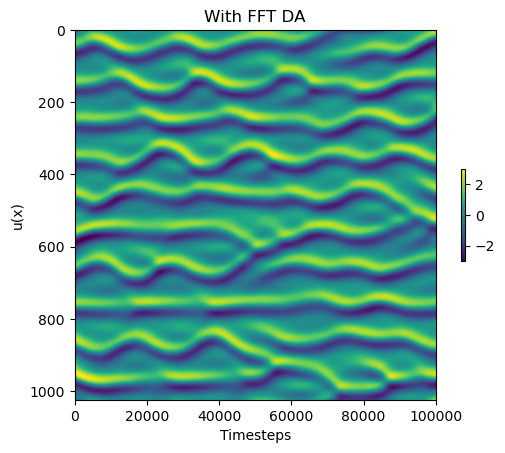

In [93]:
plt.figure(dpi=100)
plt.imshow(output_data[:,0].T,vmax=3,vmin=-3, extent=[0,100000,1024,0], aspect=100)
plt.colorbar(shrink=.25)
plt.title('With FFT DA')
plt.xlabel('Timesteps')
plt.ylabel('u(x)')
plt.savefig('Euler_tendency_noise_0_grad_fft.png', bbox_inches='tight')

In [9]:
plt.figure(dpi=100)
plt.imshow(output_data_no_fp[:,0].T,vmax=3,vmin=-3, extent=[0,99999,1024,0], aspect=100)
plt.colorbar(shrink=.25)
plt.title('No DA, noise 1.0')
plt.xlabel('Timesteps')
plt.ylabel('u(x)')
plt.savefig('Euler_tendency_noise_1.0_no_kf.png', bbox_inches='tight')

NameError: name 'output_data_no_fp' is not defined

<Figure size 640x480 with 0 Axes>

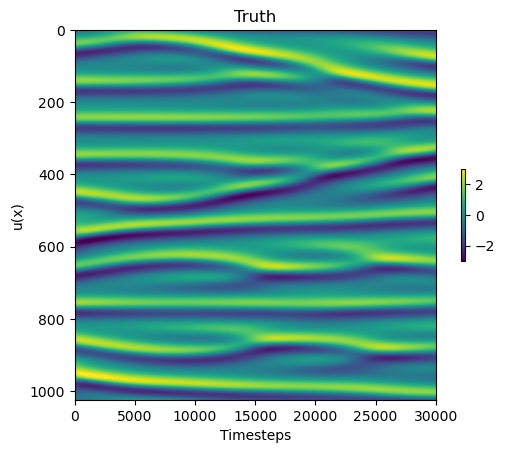

In [108]:
plt.figure(dpi=100)
plt.imshow(test[:30000].T,vmax=3,vmin=-3, extent=[0,30000,1024,0], aspect=30)
plt.colorbar(shrink=.25)
plt.title('Truth')
plt.xlabel('Timesteps')
plt.ylabel('u(x)')
plt.savefig('KS_truth_30k_dts.png', bbox_inches='tight')

Text(0, 0.5, 'u(x)')

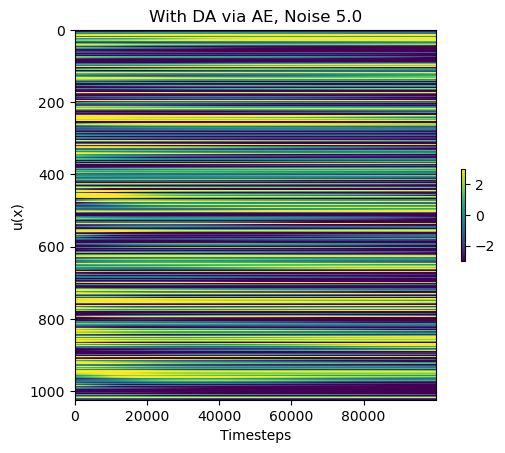

In [43]:
plt.figure(dpi=100)
plt.imshow(output_data_2[:,0].T,vmax=3,vmin=-3, extent=[0,99999,1024,0], aspect=100)
plt.colorbar(shrink=.25)
plt.title('With DA via AE, Noise 5.0')
plt.xlabel('Timesteps')
plt.ylabel('u(x)')
# plt.savefig('Euler_tendency_noise_1.0_fp_mean_ens.png', bbox_inches='tight')

Text(0, 0.5, 'u(x)')

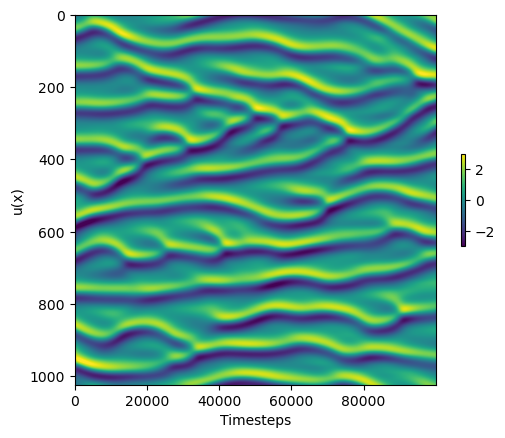

In [10]:
plt.figure(dpi=100)
plt.imshow(net_2_pred[:].T,vmax=3,vmin=-3, extent=[0,99999,1024,0], aspect=100)
plt.colorbar(shrink=.25)
# plt.title('FP every 100 dt, ens mean, noise 1.0')
plt.xlabel('Timesteps')
plt.ylabel('u(x)')
# plt.savefig('Euler_tendency_noise_1.0_fp_mean_ens.png', bbox_inches='tight')

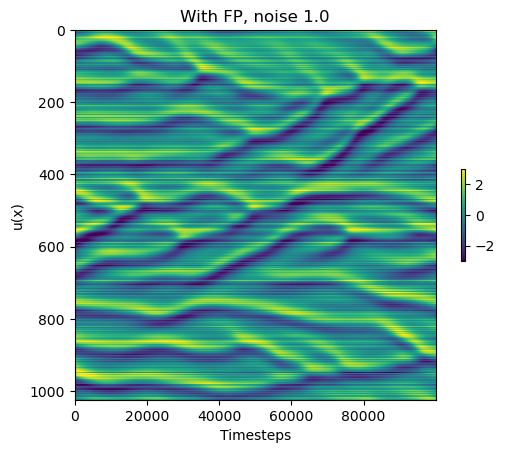

In [40]:
plt.figure(dpi=100)
plt.imshow(output_data_2_5[:,0].T,vmax=3,vmin=-3, extent=[0,99999,1024,0], aspect=100)
plt.colorbar(shrink=.25)
plt.title('With FP, noise 1.0')
plt.xlabel('Timesteps')
plt.ylabel('u(x)')
plt.savefig('Euler_tendency_noise_1.0_w_fp_mean.png', bbox_inches='tight')

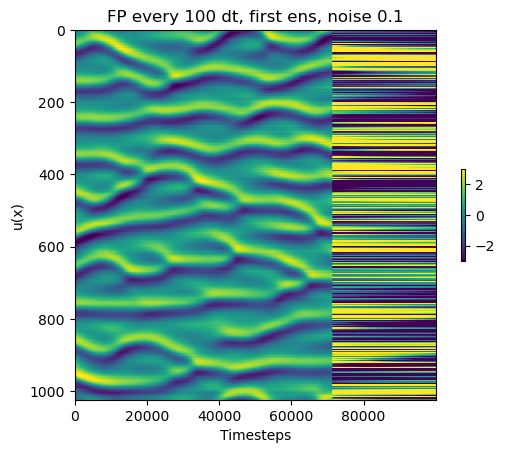

In [63]:
plt.figure(dpi=100)
plt.imshow(output_data_2[:50000,0].T,vmax=3,vmin=-3, extent=[0,99999,1024,0], aspect=100)
plt.colorbar(shrink=.25)
plt.title('FP every 100 dt, first ens, noise 0.1')
plt.xlabel('Timesteps')
plt.ylabel('u(x)')
# plt.savefig('Euler_tendency_noise_0.1_fp.png', dpi=fig.dpi, bbox_inches='tight')

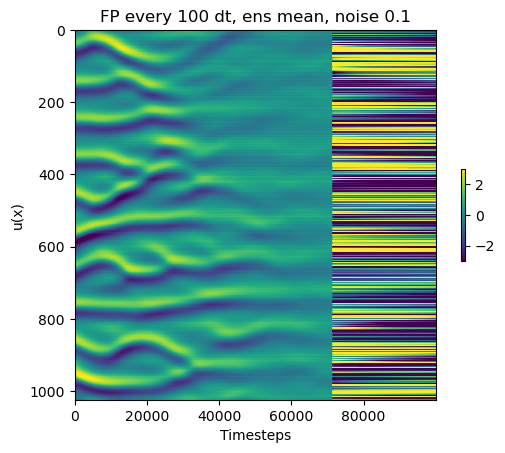

In [64]:
plt.figure(dpi=100)
plt.imshow(output_data_2[:].mean(1).T,vmax=3,vmin=-3, extent=[0,99999,1024,0], aspect=100)
plt.colorbar(shrink=.25)
plt.title('FP every 100 dt, ens mean, noise 0.1')
plt.xlabel('Timesteps')
plt.ylabel('u(x)')
plt.savefig('Euler_tendency_noise_0.1_fp_mean_ens.png', dpi=fig.dpi, bbox_inches='tight')

In [ ]:
plt.figure(dpi=100)
plt.imshow(test[:99999,:].T,vmax=3,vmin=-3, extent=[0,99999,1024,0], aspect=100)
plt.colorbar(shrink=.25)
plt.title('Truth')
plt.xlabel('Timesteps')
plt.ylabel('u(x)')
plt.savefig('Truth_state.png', dpi=fig.dpi, bbox_inches='tight')

In [55]:
trange = 100000
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_tendency_jacs_many_timesteps.npy', 'rb') as f: #change based on eval data location.
    data_dict = np.load(f, allow_pickle=True)
net_pred = data_dict.item()['prediction']
net_truth = data_dict.item()['Truth']
net_RMSE = data_dict.item()['RMSE']
net_FFT_x = data_dict.item()['pred_FFT_x']
net_jacs = data_dict.item()['Jacobians']
# net_pred_from_truch = data_dict.item()['Pred_from_Truth']
# net_truth_indices = data_dict.item()['Truth_indices']

In [87]:
(output_data_RMSE_full.shape)

torch.Size([99999, 1])

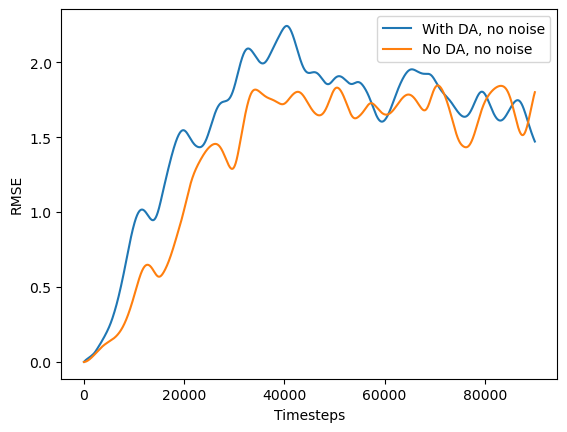

In [101]:
trange = 89999
# output_RMSE = np.sqrt(np.mean((output_data[0:trange,0] - net_truth[1:trange*100+1:100])**2), )
plt.plot(output_data_RMSE_full[:trange,0], label='With DA, no noise')
# plt.plot(output_RMSE[:trange], label='With DA w AE, noise 0')
# plt.plot(output_data_7_RMSE_full[:trange].mean(1), label='With DA fft, every 40k')
# plt.plot(output_data_RMSE_full_no_fp[:trange].mean(1),':', label='No DA fft, with noise 1.0')
# plt.plot(output_data_2_RMSE_full_no_fp[:trange,1],':', label='No DA fft, noise 5')
plt.plot(net_2_RMSE[:trange], label='No DA, no noise')

plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('RMSE')
plt.savefig('RMSE_Euler_tendnecy_da_grad_fft_no_noise.png', bbox_inches='tight')

Text(0, 0.5, 'STD')

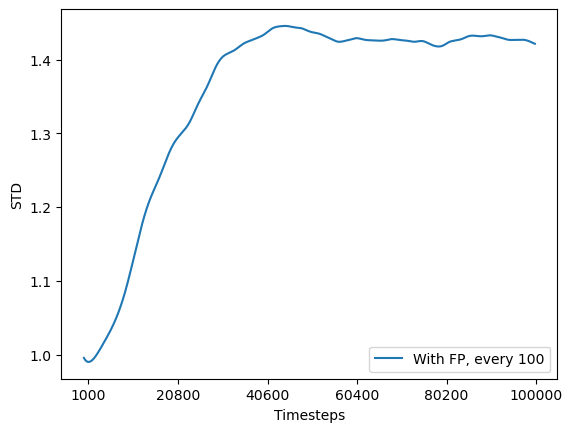

In [31]:
trange = 999
plt.plot(output_data[1:trange].std(1).mean(1), label='With FP, every 100')
# plt.plot(output_data_6[:trange].std(1).mean(1), label='With FP, every 20k')
# plt.plot(output_data_7[:trange].std(1).mean(1), label='With FP, every 40k')
# plt.plot(output_data_no_fp[:trange].std(1).mean(1),':', label='No FP')
# plt.plot(output_data_2_RMSE_full_no_fp[:trange,1],':', label='No FP, noise 5')
locs = np.linspace(10,1000, 6, dtype=int)
labels = locs * 100
plt.xticks(locs, labels)
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('STD')

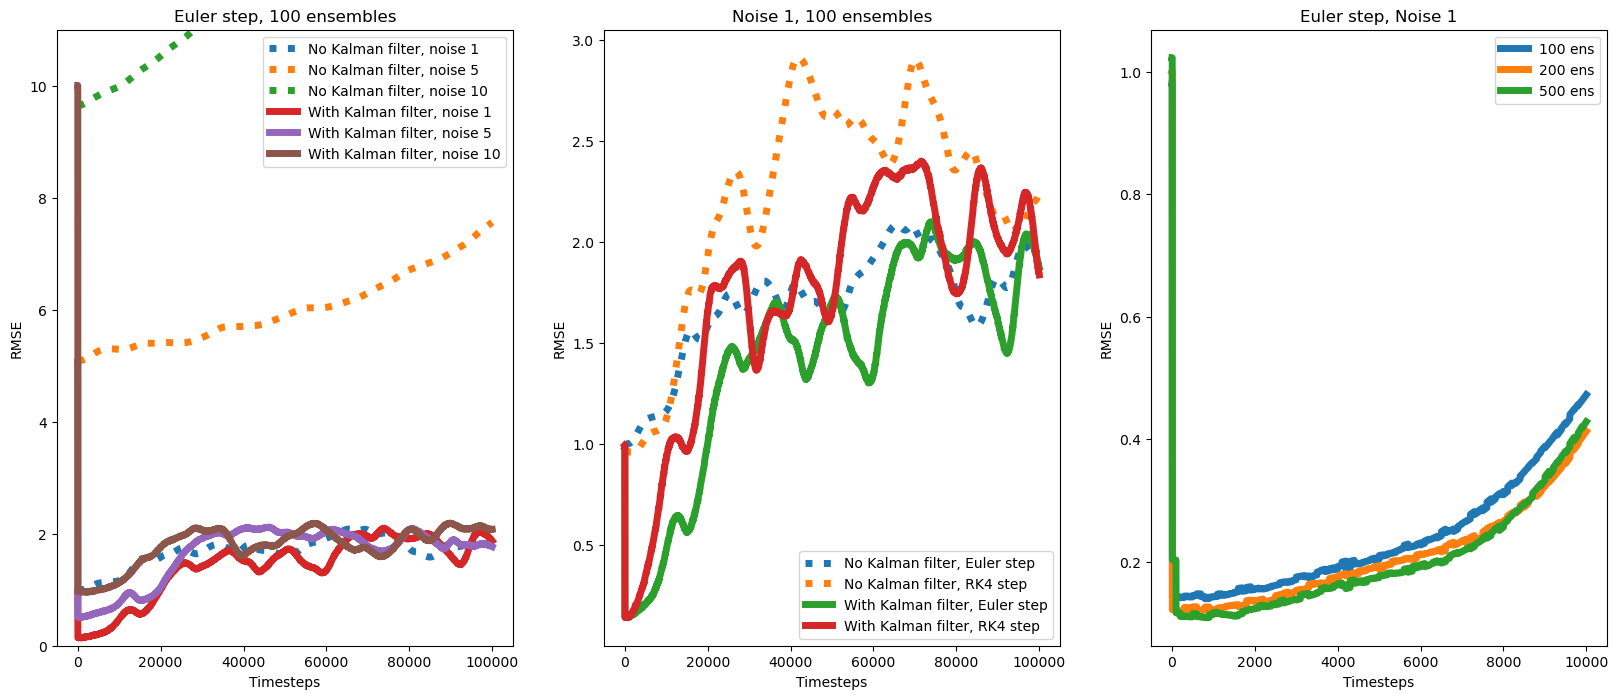

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(20,8))
trange=99999
axs[0].plot(output_data_RMSE_full_no_fp[:trange,1],':', label='No Kalman filter, noise 1', linewidth=5)
axs[0].plot(output_data_2_RMSE_full_no_fp[:trange,1],':', label='No Kalman filter, noise 5', linewidth=5)
axs[0].plot(output_data_3_RMSE_full_no_fp[:trange,1],':', label='No Kalman filter, noise 10', linewidth=5)
axs[0].plot(output_data_RMSE_full[:trange,1], label='With Kalman filter, noise 1', linewidth=5)
axs[0].plot(output_data_4_RMSE_full[:trange,1], label='With Kalman filter, noise 5', linewidth=5)
axs[0].plot(output_data_5_RMSE_full[:trange,1], label='With Kalman filter, noise 10', linewidth=5)
axs[0].set_ylabel('RMSE')
axs[0].set_xlabel('Timesteps')
axs[0].set_ylim(0,11)
axs[0].legend()
axs[0].set_title('Euler step, 100 ensembles')

trange=99999
axs[1].plot(output_data_RMSE_full_no_fp[:trange,1],':', label='No Kalman filter, Euler step', linewidth=5)
axs[1].plot(output_data_4_RMSE_full_no_fp[:trange,1],':', label='No Kalman filter, RK4 step', linewidth=5)
axs[1].plot(output_data_RMSE_full[:trange,1], label='With Kalman filter, Euler step', linewidth=5)
axs[1].plot(output_data_3_RMSE_full[:trange,1], label='With Kalman filter, RK4 step', linewidth=5)
axs[1].legend()
axs[1].set_ylabel('RMSE')
axs[1].set_xlabel('Timesteps')

axs[1].set_title('Noise 1, 100 ensembles')

trange=9999
axs[2].plot(output_data_RMSE_full[:trange,1], label='100 ens', linewidth=5)
axs[2].plot(output_data_2_RMSE_full[:trange,1], label='200 ens', linewidth=5)
axs[2].plot(output_data_2_5_RMSE_full[:trange,1], label='500 ens', linewidth=5)
axs[2].set_ylabel('RMSE')
axs[2].set_xlabel('Timesteps')

axs[2].legend()
axs[2].set_title('Euler step, Noise 1') 
plt.savefig('Kalman_figure_1.png', dpi=fig.dpi, bbox_inches='tight')

In [ ]:
plt.hist(output_data[:].flatten(),bins=100, alpha=0.75, label='With FP', density=True)
print('Done w one')
plt.hist(net_2_pred[:].flatten(),bins=100, alpha=0.25, label='No FP',density=True)
print('Done w two')
plt.hist(test[1000:,:].flatten(),bins=100, alpha=0.25, label='Truth',density=True)
plt.legend()
plt.title('PDF to 100k timesteps, Euler step, noise 1')
plt.xscale('symlog')
plt.yscale('symlog')
plt.savefig('FFT_grad_pdf.png', bbox_inches='tight')

In [16]:
net_2_pred.shape

(99998, 1024)

Done w one
Done w two


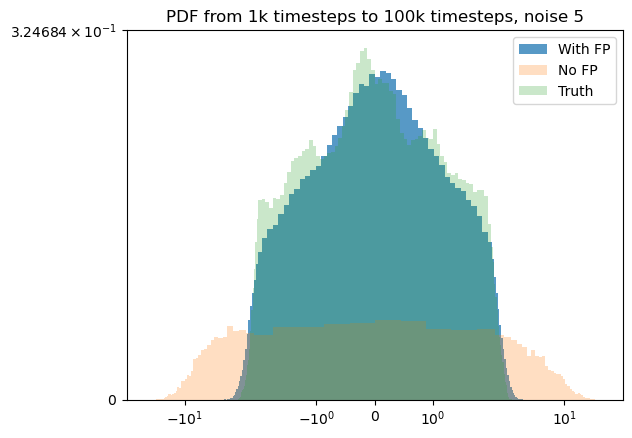

In [40]:
plt.hist(output_data_4[10:,1].flatten(),bins=100, alpha=0.75, label='With FP', density=True)
print('Done w one')
plt.hist(output_data_2_no_fp[10:,1].flatten(),bins=100, alpha=0.25, label='No FP',density=True)
print('Done w two')
plt.hist(test[1000:,:].flatten(),bins=100, alpha=0.25, label='Truth',density=True)
plt.legend()
plt.title('PDF from 1k timesteps to 100k timesteps, noise 5')
plt.xscale('symlog')
plt.yscale('symlog')

Done w one
Done w two


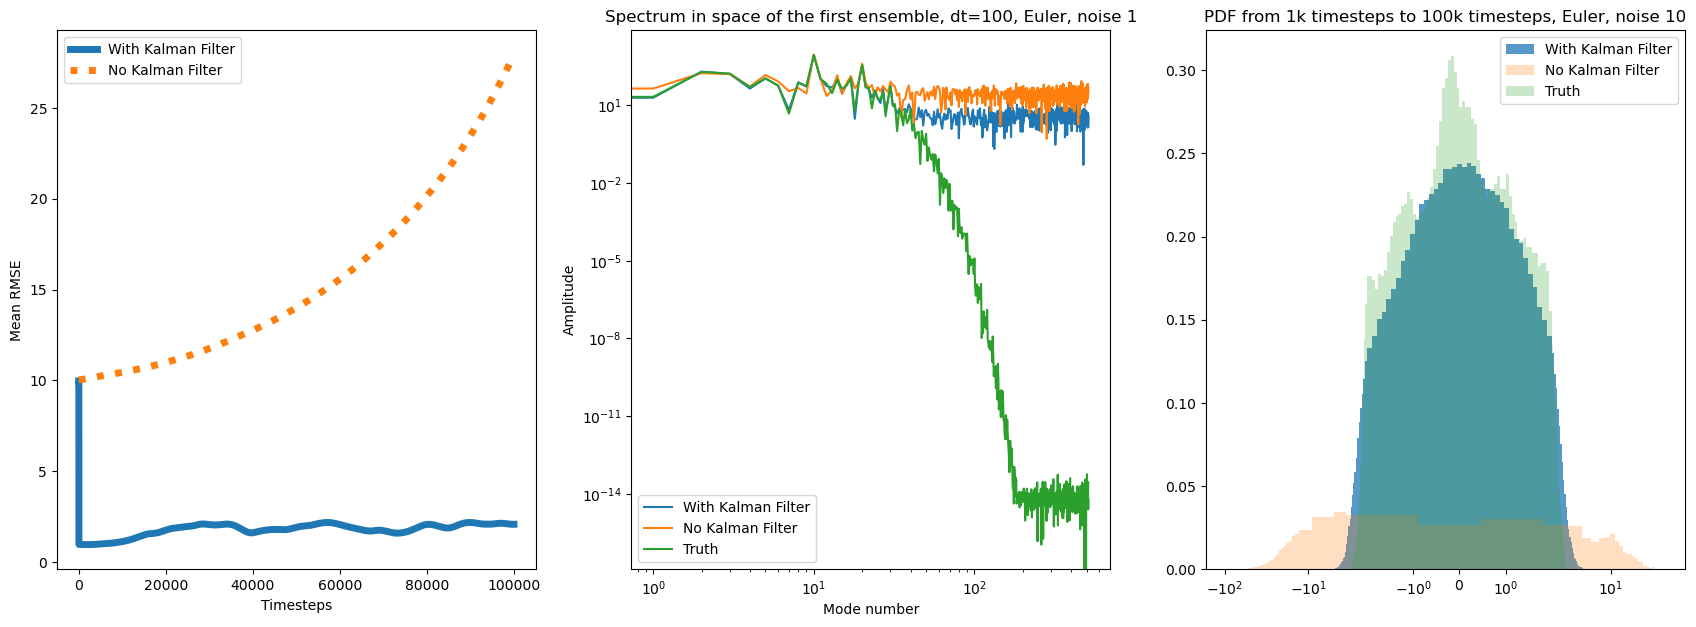

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(21,7))
trange = 99999
axs[0].plot(output_data_5_RMSE_full[:trange].mean(1), label='With Kalman Filter', linewidth=5)
axs[0].plot(output_data_3_RMSE_full_no_fp[:trange].mean(1),':', label='No Kalman Filter', linewidth=5)
axs[0].set_ylabel('Mean RMSE')
axs[0].set_xlabel('Timesteps')
axs[0].legend()
# axs[0].set_title('Mean of RMSE, Euler, noise 10')

axs[1].loglog(torch.abs(torch.fft.rfft((output_data[1,1]))), label='With Kalman Filter')
axs[1].loglog(torch.abs(torch.fft.rfft((output_data_no_fp[1,1]))), label='No Kalman Filter')
axs[1].loglog(torch.abs(torch.fft.rfft(torch.from_numpy(test[1]))), label='Truth')
axs[1].legend()
axs[1].set_title('Spectrum in space of the first ensemble, dt=100, Euler, noise 1')
axs[1].set_xlabel('Mode number')
axs[1].set_ylabel('Amplitude')

axs[2].hist(output_data_5[1:,1].flatten(),bins=100, alpha=0.75, label='With Kalman Filter', density=True)
print('Done w one')
axs[2].hist(output_data_3_no_fp[1:,1].flatten(),bins=100, alpha=0.25, label='No Kalman Filter',density=True)
print('Done w two')
axs[2].hist(test[1:,:].flatten(),bins=100, alpha=0.25, label='Truth',density=True)
axs[2].legend()
axs[2].set_title('PDF from 1k timesteps to 100k timesteps, Euler, noise 10')
axs[2].set_xscale('symlog')
# axs[2].set_yscale('symlog')
plt.savefig('Kalman_figure_2.png', dpi=fig.dpi, bbox_inches='tight')

In [71]:
output_data[1:,0].shape

torch.Size([999, 1024])

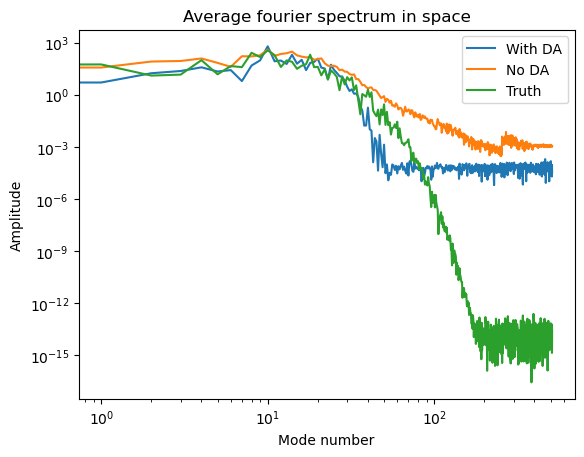

In [102]:
trange = 300
plt.loglog(torch.abs(torch.fft.rfft((output_data[1:trange,0]), dim=1).mean(0))[:512], label='With DA')

plt.loglog(torch.abs(torch.tensor(net_2_FFT_x[1:trange*100:100]).mean(0))[:512], label='No DA')

plt.loglog(torch.abs(torch.fft.rfft(torch.from_numpy(test[1:trange*100:100]), dim=1).mean(0))[:512], label='Truth')

plt.legend()
plt.title('Average fourier spectrum in space')
plt.xlabel('Mode number')
plt.ylabel('Amplitude')
plt.savefig('DA_grad_avg_fft_Euler_tendency_FNO_noise_0.png', bbox_inches='tight')

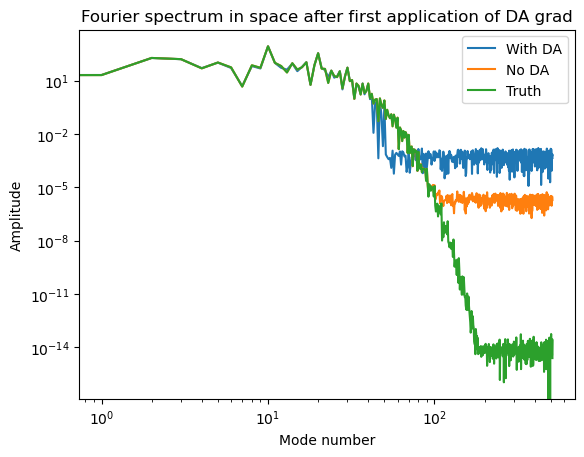

In [103]:
# plt.loglog(output_data_FFT_x[10,1],':', label='With FP')
# plt.loglog(output_data_FFT_x_no_fp[10,1],'--', label='No FP')
plt.loglog(torch.abs(torch.fft.rfft((output_data[1,0])))[:512], label='With DA')

plt.loglog(torch.abs(torch.tensor(net_2_FFT_x[1]))[:512], label='No DA')

plt.loglog(torch.abs(torch.fft.rfft(torch.from_numpy(test[1])))[:512], label='Truth')
plt.legend()
plt.title('Fourier spectrum in space after first application of DA grad')
plt.xlabel('Mode number')
plt.ylabel('Amplitude')
plt.savefig('DA_grad_fft_Euler_tendency_FNO_noise_0.png', bbox_inches='tight')

Text(0.5, 0.98, 'True')

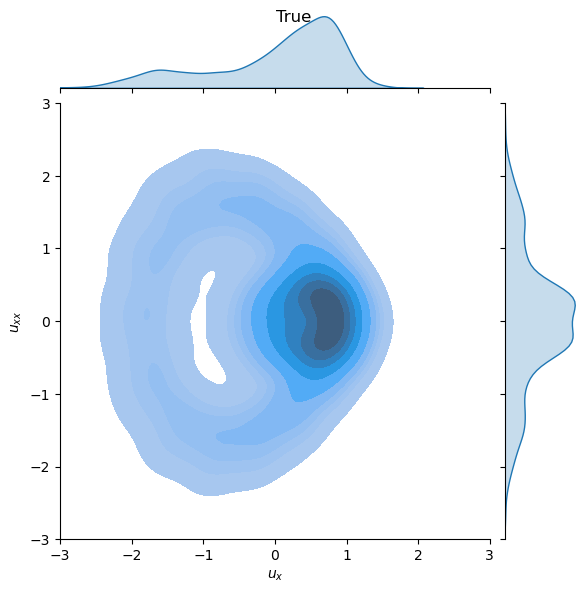

In [6]:
pred_np = pred.detach().numpy()
def u_x_xx(u):
   dx = 22/u.shape[0]
   u_x = (u[2:] - u[:-2])/(2*dx)
   u_xx = (u[2:] - 2*u[1:-1]+u[:-2])/(dx**2)
   return u_x,u_xx
u_x, u_xx = u_x_xx(pred_np[0,:,0])
df_true_1 = pd.DataFrame({'u_x':u_x,
                   'u_xx':u_xx})
for i in range(6000,7000,5): #upto 3000 rollouts
    u_1 = pred_np[i,:,0]
    u_x, u_xx = u_x_xx(u_1)
    df_true_1 = pd.concat([df_true_1,pd.DataFrame({'u_x':u_x,
            'u_xx':u_xx})], ignore_index=True)
h2 = sns.jointplot(data=df_true_1,x='u_x',y='u_xx',kind="kde",fill=True)
h2.ax_joint.set_xlabel("$u_{x}$")
h2.ax_joint.set_ylabel("$u_{xx}$")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.suptitle("True")
# plt.savefig('True_dist.png')

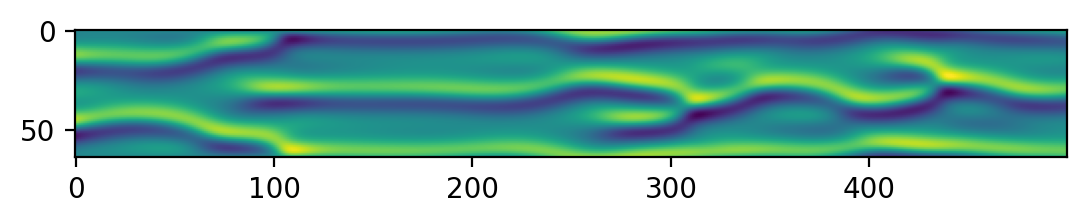

In [31]:
plt.figure(dpi=200)def fft_loss(inp,out):
        #batchsize x channels x shape
        inp_fft = torch.abs(torch.fft.fftn(inp,dim=(1))[:,:15,:])
        out_fft = torch.abs(torch.fft.fftn(out,dim=(1))[:,:15,:])
        fft_index = (inp_fft>1e-8)*(out_fft>1e-8)
        return torch.mean(torch.abs(1-(inp_fft)/(out_fft))*fft_index)

print(fft_loss(pred[1:2], test[1:2]))
plt.imshow(test.squeeze(-1)[:500,:].detach().numpy().T,vmax=3,vmin=-3)

In [ ]:
N1=64
kfreq1 = torch.fft.fftfreq(N1) * N1
#kfreq2D = torch.meshgrid(kfreq1, kfreq2)
knrm = torch.sqrt(kfreq1**2)
knrm = knrm.flatten()
idx = np.arange(knrm.shape[0])
indices = [idx[(knrm<i+0.5)] for i in range(33)]
kbins = torch.arange(0.5, N1//2+1, 1.)
hist_bins = torch.histogram(knrm, kbins)[0]


def avg_espec(input):
    # timesteps x 1 x 64
    N = input.shape[-1]
    fourier_image = torch.fft.fftn(input, dim=(1,2))
    fourier_amplitudes = 0.5*torch.sum(torch.abs(fourier_image)**2, dim=1)

    kfreq1 = torch.fft.fftfreq(N) * N
    #kfreq2D = torch.meshgrid(kfreq1, kfreq2)
    knrm = torch.sqrt(kfreq1)#(kfreq2D[0]**2 + kfreq2D[1]**2)

    #knrm = torch.flatten(knrm,start_dim=1)#knrm.flatten()
    fourier_amplitudes = torch.flatten(fourier_amplitudes,start_dim=1)#fourier_amplitudes.flatten()

    kbins = torch.arange(0.5, N//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins = torch.tensor([torch.sum(fourier_amplitudes[:,indices[i]]) - torch.sum(fourier_amplitudes[:,indices[i-1]]) for i in range(1,33)])
    Abins = Abins * kvals**2 / hist_bins
    Abins = Abins/ torch.trapezoid(Abins, kvals)
    return Abins

In [5]:
def load_output_data_jacs(num_chunks, file_path, M):

    output_data = np.zeros([int(M)+1,1024])
    output_data_RMSE = np.zeros([int(M)+1])
    output_data_FFT_X = np.zeros([int(M)+1,512])
    output_jacs = np.zeros([int(M)+1,1024,1024])
    output_jacs_true = np.zeros([int(M)+1,1024,1024])


    start_ind = 0
    for k in range(num_chunks):
        out = np.load(file_path+str(k)+'.npy', allow_pickle=True)#[10000:,:,:,:]
        t_range = out.item()['prediction'].shape[0]
        output_data[start_ind:start_ind+t_range] = out.item()['prediction']
        output_data_RMSE[start_ind:start_ind+t_range] = out.item()['RMSE']
        output_data_FFT_X[start_ind:start_ind+t_range,:512] = out.item()['pred_FFT_x'][:,:512]
        output_jacs[start_ind:start_ind+t_range] = out.item()['Jacobians']
        output_jacs_true[start_ind:start_ind+t_range] = out.item()['Jacobians_truth']

        start_ind += t_range
        # print(start_ind)

    return torch.from_numpy(output_data).float(), torch.from_numpy(output_data_RMSE).float(), torch.from_numpy(output_data_FFT_X).float(), torch.from_numpy(output_jacs).float(), torch.from_numpy(output_jacs_true).float()


In [6]:
# with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_jacs_for_1k.npy', 'rb') as f: #change based on eval data location.
#     data_dict = np.load(f, allow_pickle=True)
# net_pred = data_dict.item()['prediction']
# net_truth = data_dict.item()['Truth']
# net_RMSE = data_dict.item()['RMSE']
# net_FFT_x = data_dict.item()['pred_FFT_x']
# net_jacs = data_dict.item()['Jacobians']

with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_RK4step_tendency_FNO_jacs_for_1k.npy', 'rb') as f: #change based on eval data location.
    data_dict = np.load(f, allow_pickle=True)
net_2_pred = data_dict.item()['prediction']
net_2_truth = data_dict.item()['Truth']
net_2_RMSE = data_dict.item()['RMSE']
net_2_FFT_x = data_dict.item()['pred_FFT_x']
net_2_jacs = data_dict.item()['Jacobians']

# with open('/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_spectral_jac_loss_MLP_jacs_many_timesteps.npy', 'rb') as f: #change based on eval data location.
#     data_dict = np.load(f, allow_pickle=True)
# net_3_pred = data_dict.item()['prediction']
# net_3_truth = data_dict.item()['Truth']
# net_3_RMSE = data_dict.item()['RMSE']
# net_3_FFT_x = data_dict.item()['pred_FFT_x']
# net_3_jacs = data_dict.item()['Jacobians']


In [7]:
file_path = '/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_FNO_jacs_for_1k/KS_pred_Eulerstep_FNO_jacs_for_1k_chunk_'

M = 999
num_chunks = 100
net_pred, net_RMSE, net_FFT_x, net_jacs, net_jacs_true = load_output_data_jacs(num_chunks, file_path, M)

In [8]:
file_path = '/glade/derecho/scratch/cainslie/conrad_net_stability/Net_output_pred_jacs/KS_pred_Eulerstep_spectral_jacobian_FNO_jacs_for_1k/KS_pred_Eulerstep_spectral_jacobian_FNO_jacs_for_1k_chunk_'

M = 999
num_chunks = 100
net_3_pred, net_3_RMSE, net_3_FFT_x, net_3_jacs, net_3_jacs_true = load_output_data_jacs(num_chunks, file_path, M)

In [ ]:
net_eigs, net_eigvecs = torch.linalg.eig(net_jacs)
# net_eigs, net_eigvecs = torch.linalg.eig(torch.tensor(net_jacs).cuda())
print('First done')

net_2_eigs, net_2_eigvecs = torch.linalg.eig(torch.tensor(net_2_jacs))
# net_2_eigs, net_2_eigvecs = torch.linalg.eig(torch.tensor(net_2_jacs).cuda())
print('Second done')

net_3_eigs, net_3_eigvecs = torch.linalg.eig(net_3_jacs)
# net_3_eigs, net_3_eigvecs = torch.linalg.eig(torch.tensor(net_3_jacs).cuda())
print('Third done')

In [11]:
net_3_eigs, net_3_eigvecs = torch.linalg.eig((net_3_jacs))
# net_3_eigs, net_3_eigvecs = torch.linalg.eig(torch.tensor(net_3_jacs).cuda())
print('Third done')

Third done


In [ ]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
scat =  ax.scatter(net_eigs.cpu()[0].real, net_eigs.cpu()[0].imag, label='Euler FNO Eigs')
scat2 =  ax.scatter(net_2_eigs.cpu()[0].real, net_2_eigs.cpu()[0].imag, marker='*', label='RK4 tendency FNO Eigs')
scat3 =  ax.scatter(net_3_eigs.cpu()[0].real, net_3_eigs.cpu()[0].imag, marker='^', label='Euler Spectral Jac FNO Eigs')


xlims = plt.xlim()
ylims = plt.ylim()
t = np.linspace(0,np.pi*2,10000)
line2 = plt.plot(np.cos(t), np.sin(t), ':', linewidth=2, label='Unit circle')

ax.set(xlim=xlims, ylim=ylims)
ax.set_xlabel(r'$Re(\lambda)$', fontsize=40)
ax.set_ylabel(r'$Im(\lambda)$', fontsize=40)
ax.legend()

def update(frame):
    # for each frame, update the data stored on each artist.
    x = net_eigs.cpu()[frame].real
    y = net_eigs.cpu()[frame].imag
    # update the scatter plot:
    data = np.stack([x, y]).T
    scat.set_offsets(data)
    x = net_2_eigs.cpu()[frame].real
    y = net_2_eigs.cpu()[frame].imag
    # update the scatter plot:
    data = np.stack([x, y]).T
    scat2.set_offsets(data)
    x = net_3_eigs.cpu()[frame].real
    y = net_3_eigs.cpu()[frame].imag
    # update the scatter plot:
    data = np.stack([x, y]).T
    scat3.set_offsets(data)

    
    
    # update the line plot:
    return (scat, scat2, scat3, line2)



anim = animation.FuncAnimation(fig=fig, func=update, frames=1000, interval=5)
anim.save('FNO_Euler_Euler_specjac_RK4_tendency_eigs_cpu.mp4', writer="ffmpeg")
plt.show()

In [ ]:
tdiff = 20
sing_vals = 40
net_eigs_sorted_dt0, net_eigs_inds_dt0 = torch.sort(net_eigs[0].abs(), 0, descending=True) #sorted largest to smallest
net_eigvecs_sorted_dt0 = net_eigvecs[0][net_eigs_inds_dt0]

net_eigs_sorted_dt1, net_eigs_inds_dt1 = torch.sort(net_eigs[tdiff].abs(), 0, descending=True)
net_eigvecs_sorted_dt1 = net_eigvecs[tdiff][net_eigs_inds_dt1]
C_mat = (torch.conj(net_eigvecs_sorted_dt0[:,-sing_vals:]).T @ net_eigvecs_sorted_dt1[:,-sing_vals:])
Q, S, W = torch.svd(C_mat)

net_2_eigs_sorted_dt0, net_2_eigs_inds_dt0 = torch.sort(net_2_eigs[0].abs(), 0, descending=True) #sorted largest to smallest
net_2_eigvecs_sorted_dt0 = net_2_eigvecs[0][net_2_eigs_inds_dt0]

net_2_eigs_sorted_dt1, net_2_eigs_inds_dt1 = torch.sort(net_2_eigs[tdiff].abs(), 0, descending=True)
net_2_eigvecs_sorted_dt1 = net_2_eigvecs[tdiff][net_2_eigs_inds_dt1]
C_mat_2 = (torch.conj(net_2_eigvecs_sorted_dt0[:,-sing_vals:]).T @ net_2_eigvecs_sorted_dt1[:,-sing_vals:])
Q_2, S_2, W_2 = torch.svd(C_mat_2)



plt.plot(S[:].cpu(), label='Euler FNO')
plt.plot(S_2[:].cpu(),':', label='RK4 tendency FNO')
plt.legend()

In [39]:
tdiff = 100
sing_vals = 20

U, S, V_t = np.linalg.svd((net_jacs[0]))
V = V_t.T

U_dt0, S_dt0, V_t_dt0 = np.linalg.svd((net_jacs[tdiff]))
V_dt0 = V_t_dt0.T

C_mat = (np.conj(V[:,-sing_vals:]).T @ V_dt0[:,-sing_vals:])
C_U, C_S, C_W = np.linalg.svd(C_mat)
print('First done')


U_2, S_2, V_2_t  = np.linalg.svd((net_2_jacs[0]))
V_2 = V_2_t.T

U_2_dt0, S_2_dt0, V_2_t_dt0  = np.linalg.svd((net_2_jacs[tdiff]))
V_2_dt0 = V_2_t_dt0.T

C_2_mat = (np.conj(V_2[:,-sing_vals:]).T @ V_2_dt0[:,-sing_vals:])
C_2_U, C_2_S, C_2_W = np.linalg.svd(C_2_mat)
print('Second done')


U_3, S_3, V_3_t  = np.linalg.svd((net_3_jacs[0]))
V_3 = V_3_t.T

U_3_dt0, S_3_dt0, V_3_t_dt0  = np.linalg.svd((net_3_jacs[tdiff]))
V_3_dt0 = V_3_t_dt0.T

C_3_mat = (np.conj(V_3[:,-sing_vals:]).T @ V_3_dt0[:,-sing_vals:])
C_3_U, C_3_S, C_3_W = np.linalg.svd(C_3_mat)
print('Third done')


plt.plot(C_S[:], label='Euler FNO')
plt.plot(C_2_S[:],':', label='RK4 tendency FNO')
plt.plot(C_3_S[:],'*', label='Euler Spectral Jacobian FNO')
plt.legend()
plt.ticklabel_format(useOffset=False, style='plain')
plt.title('Covariance singular values after 1k timesteps')
plt.savefig('Cov_1k.png')

IndexError: index 100 is out of bounds for axis 0 with size 10

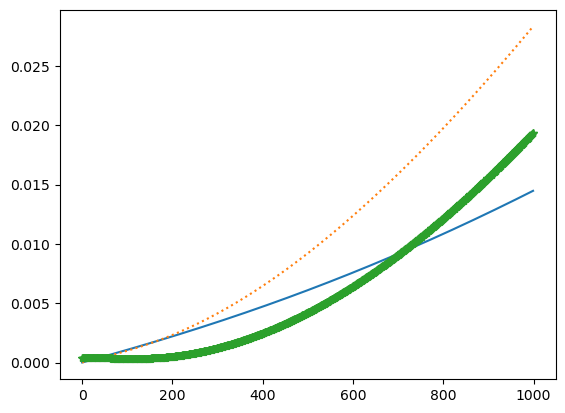

In [26]:
plt.plot(net_RMSE)
plt.plot(net_2_RMSE,':')
plt.plot(net_3_RMSE,'*')